In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import missingno as msno  # pip install missingno
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

from sklearn import *
import gc
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
building = pd.read_csv('./ashrae-energy-prediction/building_metadata.csv')
weather_train = pd.read_csv('./ashrae-energy-prediction/weather_train.csv')
weather_test = pd.read_csv('./ashrae-energy-prediction/weather_test.csv')
train = pd.read_csv('./ashrae-energy-prediction/train.csv')
test = pd.read_csv('./ashrae-energy-prediction/test.csv')

In [3]:
# building, weather, train 파일의 조인관계 도식화
# merge 전 building과 weather 데이터의 결측치를 먼저 해결하기

print(building.shape)
print(weather_train.shape)
print(train.shape)

(1449, 6)
(139773, 9)
(20216100, 4)


In [124]:
building.isna().mean()

site_id        0.000000
building_id    0.000000
primary_use    0.000000
square_feet    0.000000
year_built     0.534161
floor_count    0.755003
dtype: float64

In [3]:
# floor_count의 null값이 76%에 달하여 값이 있으면 1, 없으면 0으로 카테고리화
building['floor_count'] = building['floor_count'].isna()
building['floor_count'] = np.where((building.floor_count == True), 1, building.floor_count)
building['floor_count'] = np.where((building.floor_count == False), 0, building.floor_count)

In [24]:
temp = building.groupby('site_id').agg(['mean','median'])
temp

building_id            square_feet             year_built          \
               mean  median           mean    median         mean  median   
site_id                                                                     
0              52.0    52.0   86394.638095   52957.0  1995.542857  2001.0   
1             130.0   130.0   65002.392157   57673.0  1961.475000  1960.0   
2             223.0   223.0   99542.214815   71421.0  1974.882979  1973.5   
3             427.5   427.5   75290.383212   35137.0  1961.727273  1961.5   
4             610.0   610.0   92876.241758   68146.0  1954.123596  1955.0   
5             700.0   700.0   47612.415730   28363.0  1962.602273  1976.0   
6             766.5   766.5   91857.704545   67430.0          NaN     NaN   
7             796.0   796.0  323634.533333  290625.0  1958.500000  1963.0   
8             838.5   838.5   29712.200000    7556.0          NaN     NaN   
9             935.5   935.5  144874.209677  102739.5          NaN     NaN   
10           1012.5  1012.5   71152.566667   59499.5          NaN     NaN   
11           1030.0  1030.0  104563.400000   93206.0          NaN     NaN   
12           1050.5  1050.5   79338.611111   56978.5          NaN     NaN   
13           1145.5  1145.5  128342.090909   89657.0          NaN     NaN   
14           1273.5  1273.5   95111.441176   69256.5          NaN     NaN   
15           1386.5  1386.5   83921.387097   65831.0  1962.371681  1964.0   

        floor_count         
               mean median  
site_id                     
0              1.00   True  
1              0.00  False  
2              1.00   True  
3              1.00   True  
4              0.00  False  
5              0.00  False  
6              1.00   True  
7              0.00  False  
8              0.00  False  
9              1.00   True  
10             0.00  False  
11             1.00   True  
12             0.75   True  
13             1.00   True  
14             1.00   True  
15             1.00   True

In [26]:
temp = building[building["year_built"].isna()]
temp['site_id'].value_counts()

13    154
3     142
9     124
14    102
8      70
6      44
2      41
12     36
10     30
1      11
15     11
11      5
4       2
5       1
7       1
Name: site_id, dtype: int64

In [4]:
building['year_built'].fillna(building.groupby("site_id")["year_built"].transform("median"), inplace=True)
building.isna().mean()

site_id        0.000000
building_id    0.000000
primary_use    0.000000
square_feet    0.000000
year_built     0.389924
floor_count    0.000000
dtype: float64

In [29]:
temp = building.groupby('site_id').agg(['mean','median'])
temp

building_id            square_feet             year_built          \
               mean  median           mean    median         mean  median   
site_id                                                                     
0              52.0    52.0   86394.638095   52957.0  1995.542857  2001.0   
1             130.0   130.0   65002.392157   57673.0  1961.156863  1960.0   
2             223.0   223.0   99542.214815   71421.0  1974.462963  1973.5   
3             427.5   427.5   75290.383212   35137.0  1961.609489  1961.5   
4             610.0   610.0   92876.241758   68146.0  1954.142857  1955.0   
5             700.0   700.0   47612.415730   28363.0  1962.752809  1976.0   
6             766.5   766.5   91857.704545   67430.0          NaN     NaN   
7             796.0   796.0  323634.533333  290625.0  1958.800000  1963.0   
8             838.5   838.5   29712.200000    7556.0          NaN     NaN   
9             935.5   935.5  144874.209677  102739.5          NaN     NaN   
10           1012.5  1012.5   71152.566667   59499.5          NaN     NaN   
11           1030.0  1030.0  104563.400000   93206.0          NaN     NaN   
12           1050.5  1050.5   79338.611111   56978.5          NaN     NaN   
13           1145.5  1145.5  128342.090909   89657.0          NaN     NaN   
14           1273.5  1273.5   95111.441176   69256.5          NaN     NaN   
15           1386.5  1386.5   83921.387097   65831.0  1962.516129  1964.0   

        floor_count         
               mean median  
site_id                     
0              1.00   True  
1              0.00  False  
2              1.00   True  
3              1.00   True  
4              0.00  False  
5              0.00  False  
6              1.00   True  
7              0.00  False  
8              0.00  False  
9              1.00   True  
10             0.00  False  
11             1.00   True  
12             0.75   True  
13             1.00   True  
14             1.00   True  
15             1.00   True

In [5]:
building['year_built'].fillna(building['year_built'].median(), inplace=True)
building.isna().mean()

site_id        0.0
building_id    0.0
primary_use    0.0
square_feet    0.0
year_built     0.0
floor_count    0.0
dtype: float64

In [149]:
weather_train.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [7]:
weather_train.head(3) 

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.0
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.5
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.0


In [77]:
# 강수량 컬럼에 음수값은 null로 바꿔줄 필요가 있음
weather_train.describe()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139718.000000,70600.000000,139660.000000,89484.000000,129155.000000,133505.000000,139469.000000
mean,7.478977,14.418106,2.149306,7.350158,0.983047,1016.158038,180.526632,3.560527
std,4.604744,10.626595,2.599150,9.790235,8.463678,7.629684,111.523629,2.335874
min,0.000000,-28.900000,0.000000,-35.000000,-1.000000,968.200000,0.000000,0.000000
25%,3.000000,7.200000,0.000000,0.600000,0.000000,1011.800000,80.000000,2.100000
50%,7.000000,15.000000,2.000000,8.300000,0.000000,1016.400000,190.000000,3.100000
75%,11.000000,22.200000,4.000000,14.400000,0.000000,1020.800000,280.000000,5.000000
max,15.000000,47.200000,9.000000,26.100000,343.000000,1045.500000,360.000000,19.000000


In [6]:
weather_train.loc[(weather_train.precip_depth_1_hr < 0), 'precip_depth_1_hr'] = None

In [80]:
weather_train.loc[15760:15765]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
15760,1,2016-10-18 10:00:00,12.5,NaN,8.6,NaN,1019.1,270.0,6.2
15761,1,2016-10-18 11:00:00,13.3,NaN,6.8,NaN,1019.4,290.0,6.2
15762,1,2016-10-18 12:00:00,12.8,NaN,4.7,NaN,1019.5,290.0,6.7
15763,1,2016-10-18 13:00:00,NaN,NaN,NaN,NaN,NaN,290.0,6.2
15764,1,2016-10-18 14:00:00,14.0,NaN,4.0,NaN,1019.5,280.0,6.2
15765,1,2016-10-18 15:00:00,13.0,NaN,3.6,NaN,1019.7,280.0,6.2


In [7]:
# 첫번째
# python timeseries missing value 구글링

weather_train = weather_train.groupby('site_id').apply(lambda x: x.interpolate(method='index'))
weather_train = weather_train.groupby('site_id').apply(lambda x: x.bfill())
weather_train = weather_train.groupby('site_id').apply(lambda x: x.ffill())

weather_test = weather_test.groupby('site_id').apply(lambda x: x.interpolate(method='index'))
weather_test = weather_test.groupby('site_id').apply(lambda x: x.bfill())
weather_test = weather_test.groupby('site_id').apply(lambda x: x.ffill())

weather_train.loc[15760:15765]

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
15760,1,2016-10-18 10:00:00,12.5,0.0,8.60,NaN,1019.1,270.0,6.2
15761,1,2016-10-18 11:00:00,13.3,0.0,6.80,NaN,1019.4,290.0,6.2
15762,1,2016-10-18 12:00:00,12.8,0.0,4.70,NaN,1019.5,290.0,6.7
15763,1,2016-10-18 13:00:00,13.4,0.0,4.35,NaN,1019.5,290.0,6.2
15764,1,2016-10-18 14:00:00,14.0,0.0,4.00,NaN,1019.5,280.0,6.2
15765,1,2016-10-18 15:00:00,13.0,0.0,3.60,NaN,1019.7,280.0,6.2


In [82]:
weather_train.isna().sum()

site_id                   0
timestamp                 0
air_temperature           0
cloud_coverage        17228
dew_temperature           0
precip_depth_1_hr     26273
sea_level_pressure     8755
wind_direction            0
wind_speed                0
dtype: int64

In [83]:
# 두번째. 서로 상관관계가 높은 site_id의 mean이나 median 값으로 결측치 채워주기 
# mean과 median의 차이가 크다면 이상치가 있다는 것이므로 이상치에 robust한 median을 사용

temp = weather_train.groupby('site_id').agg(['mean','median'])
temp

air_temperature        cloud_coverage           dew_temperature  \
                   mean median           mean    median            mean   
site_id                                                                   
0             22.832115   23.9       4.278518  4.000000       16.816029   
1             11.711994   11.3       0.207977  0.000000        7.646097   
2             24.941051   25.6       2.922350  2.000000        4.071257   
3             15.523195   15.6       5.033998  6.000000        8.127084   
4             15.236366   15.0       2.473813  2.000000        9.895531   
5             10.867162   11.0       0.498572  0.000000        8.194232   
6             15.131138   16.1       1.392280  0.000000        7.309964   
7              7.888867    7.7            NaN       NaN        1.905537   
8             22.832115   23.9       4.278518  4.000000       16.816029   
9             21.364385   22.2       1.126936  0.000000       14.607694   
10            11.659696   11.7       0.975632  0.000000        0.098565   
11             7.888867    7.7            NaN       NaN        1.905537   
12             9.843232    9.8       5.728555  7.000000        6.519966   
13             9.878618   11.1       4.757657  5.333333        3.400968   
14            13.260066   13.3       1.132619  0.000000        5.776587   
15             9.357618    9.4       2.061273  2.000000        4.145363   

               precip_depth_1_hr           sea_level_pressure          \
        median              mean    median               mean  median   
site_id                                                                 
0         18.3          1.685394  0.000000        1017.973725  1018.0   
1          7.8               NaN       NaN        1015.962479  1017.6   
2          3.3          0.244279  0.000000        1011.684601  1011.0   
3          9.4          1.130353  0.000000        1017.875917  1017.9   
4         10.6          0.444381  0.000000        1016.878327  1016.6   
5          8.0               NaN       NaN                NaN     NaN   
6          8.9          1.097586  0.000000        1017.505779  1017.5   
7          2.4         11.641049  4.321092        1015.249182  1015.2   
8         18.3          1.685394  0.000000        1017.973725  1018.0   
9         17.2          0.974146  0.000000        1016.571993  1015.7   
10         0.6          0.632772  0.000000        1015.595553  1014.3   
11         2.4         11.641049  4.321092        1015.249182  1015.2   
12         6.7               NaN       NaN        1014.367961  1015.8   
13         3.9          1.249459  0.000000        1015.869054  1015.9   
14         6.1          0.960351  0.000000        1016.313444  1016.5   
15         4.4         12.188313  4.815965        1016.989993  1017.3   

        wind_direction        wind_speed         
                  mean median       mean median  
site_id                                          
0           156.767987  140.0   3.375114    3.1  
1           195.566587  220.0   3.967043    3.6  
2           153.229534  130.0   2.933758    2.6  
3           184.764237  190.0   3.911082    3.6  
4           207.985313  260.0   3.858226    3.6  
5           199.544832  240.0   4.767647    4.6  
6           135.261330  160.0   2.201930    2.1  
7           208.931739  230.0   3.445565    3.1  
8           156.767987  140.0   3.375114    3.1  
9           120.513667  130.0   2.089328    2.1  
10          180.616602  170.0   3.161717    3.1  
11          208.931739  230.0   3.445565    3.1  
12          202.768132  230.0   5.511399    5.0  
13          187.161562  180.0   4.197700    4.1  
14          187.427025  210.0   3.074183    2.6  
15          186.199432  180.0   3.642033    3.1

<AxesSubplot:xlabel='site_id', ylabel='site_id'>

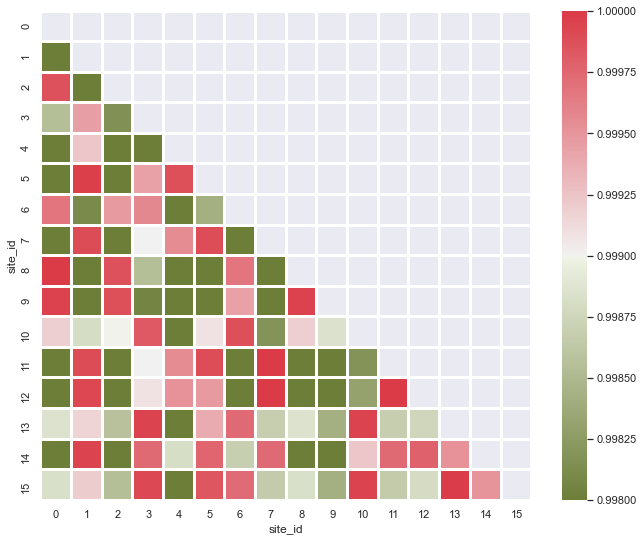

In [136]:
temp = weather_train.groupby('site_id').median()
corr = temp.transpose().corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(11,9))
cmap = sns.diverging_palette(100, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=0.998, center=0.999, linewidths=2)

In [84]:
temp = weather_train[weather_train["cloud_coverage"].isna()]
temp['site_id'].value_counts()

7     8614
11    8614
Name: site_id, dtype: int64

In [85]:
temp = weather_train[weather_train['precip_depth_1_hr'].isna()]
temp['site_id'].value_counts()

1     8763
5     8755
12    8755
Name: site_id, dtype: int64

In [86]:
temp = weather_train[weather_train['sea_level_pressure'].isna()]
temp['site_id'].value_counts()

5    8755
Name: site_id, dtype: int64

In [87]:
temp = weather_train[weather_train["cloud_coverage"].isna()]
temp = weather_train.groupby('site_id').mean()
temp = temp.transpose().corr()
temp[7] #site12 mean

site_id
0     0.998080
1     0.999854
2     0.998102
3     0.999545
4     0.999851
5     0.999782
6     0.997081
7     1.000000
8     0.998080
9     0.995475
10    0.999571
11    1.000000
12    0.999961
13    0.999718
14    0.999671
15    0.999705
Name: 7, dtype: float64

In [88]:
temp[11] #site12 mean

site_id
0     0.998080
1     0.999854
2     0.998102
3     0.999545
4     0.999851
5     0.999782
6     0.997081
7     1.000000
8     0.998080
9     0.995475
10    0.999571
11    1.000000
12    0.999961
13    0.999718
14    0.999671
15    0.999705
Name: 11, dtype: float64

In [152]:
temp = weather_train[weather_train['precip_depth_1_hr'].isna()]
temp = weather_train.groupby('site_id').median()
temp = temp.transpose().corr()
temp[1] #14 mean

site_id
0     0.996199
1     1.000000
2     0.995631
3     0.999450
4     0.999237
5     0.999975
6     0.998103
7     0.999904
8     0.996199
9     0.995462
10    0.998809
11    0.999904
12    0.999928
13    0.999158
14    0.999948
15    0.999211
Name: 1, dtype: float64

In [90]:
temp[5] #4 mean

site_id
0     0.992525
1     0.999975
2     0.988187
3     0.999435
4     0.999889
5     1.000000
6     0.998429
7     0.999894
8     0.992525
9     0.990220
10    0.999086
11    0.999894
12    0.999477
13    0.999386
14    0.999763
15    0.999845
Name: 5, dtype: float64

In [91]:
temp[12] #7 or 11 median

site_id
0     0.995269
1     0.999928
2     0.994675
3     0.999092
4     0.999521
5     0.999477
6     0.997437
7     0.999995
8     0.995269
9     0.994439
10    0.998307
11    0.999995
12    1.000000
13    0.998757
14    0.999784
15    0.998801
Name: 12, dtype: float64

In [92]:
temp = weather_train[weather_train['sea_level_pressure'].isna()]
temp = weather_train.groupby('site_id').mean()
temp = temp.transpose().corr()
temp[5] #site1 mean

site_id
0     0.996082
1     0.999968
2     0.993404
3     0.999481
4     0.999797
5     1.000000
6     0.998368
7     0.999782
8     0.996082
9     0.991596
10    0.999016
11    0.999782
12    0.999511
13    0.999302
14    0.999709
15    0.999750
Name: 5, dtype: float64

In [8]:
val = weather_train.loc[weather_train["site_id"]==12]["cloud_coverage"].mean()
weather_train["cloud_coverage"].fillna(val, inplace=True)
# weather_train[weather_train['site_id'].isin([7, 11])] = weather_train[weather_train['site_id'].isin([7, 11])].fillna( weather_train[weather_train['site_id']== 12]['cloud_coverage'].mean() )

In [9]:
mask = weather_train["site_id"]==1
val = weather_train.loc[weather_train["site_id"]==14]["precip_depth_1_hr"].mean()
weather_train.loc[mask, "precip_depth_1_hr"] = weather_train.loc[mask, "precip_depth_1_hr"].fillna(val)

In [10]:
mask = weather_train["site_id"]==5
val = weather_train.loc[weather_train["site_id"]==4]["precip_depth_1_hr"].median()
weather_train.loc[mask, "precip_depth_1_hr"] = weather_train.loc[mask, "precip_depth_1_hr"].fillna(val)

In [11]:
mask = weather_train["site_id"]==12
val = weather_train.loc[weather_train["site_id"]==7]["precip_depth_1_hr"].median()
weather_train.loc[mask, "precip_depth_1_hr"] = weather_train.loc[mask, "precip_depth_1_hr"].fillna(val)

In [12]:
mask = weather_train["site_id"]==5
val = weather_train.loc[weather_train["site_id"]==1]["sea_level_pressure"].mean()
weather_train.loc[mask, "sea_level_pressure"] = weather_train.loc[mask, "sea_level_pressure"].fillna(val)

In [99]:
weather_train.isna().sum()

site_id               0
timestamp             0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

In [100]:
weather_test.isna().sum()

site_id                   0
timestamp                 0
air_temperature           0
cloud_coverage        33146
dew_temperature           0
precip_depth_1_hr     51807
sea_level_pressure    17241
wind_direction            0
wind_speed                0
dtype: int64

In [101]:
temp = weather_test.groupby('site_id').agg(['mean','median'])
temp

air_temperature        cloud_coverage           dew_temperature  \
                   mean median           mean    median            mean   
site_id                                                                   
0             22.699104   23.9       4.184503  4.000000       17.660725   
1             12.173119   11.8       0.091890  0.000000        7.540863   
2             24.975422   25.0       3.205708  3.000000        3.817186   
3             15.493381   16.1       5.323885  6.000000        8.365519   
4             14.469131   14.4       2.484157  2.000000        9.803537   
5             11.155443   11.0       0.691665  0.000000        8.433502   
6             15.235186   16.1       1.396766  0.000000        7.867162   
7              7.407512    7.7            NaN       NaN        2.125777   
8             22.699104   23.9       4.184503  4.000000       17.660725   
9             21.299296   22.8       1.189291  0.000000       13.411656   
10            11.737391   10.6       0.932479  0.000000       -0.496881   
11             7.407512    7.7            NaN       NaN        2.125777   
12            10.017796   10.1       5.637190  7.000000        6.781289   
13             8.731771    8.9       4.662309  5.000000        2.553490   
14            13.037080   13.3       1.587606  0.222222        6.833124   
15             8.944460    9.4       1.942736  2.000000        4.699625   

               precip_depth_1_hr           sea_level_pressure          \
        median              mean    median               mean  median   
site_id                                                                 
0         19.4          1.167295  0.000000        1017.903616  1017.9   
1          8.0               NaN       NaN        1015.645745  1016.7   
2          2.8          0.153938  0.000000        1011.309695  1010.6   
3         10.0          0.995776  0.000000        1018.012125  1017.7   
4         10.6          0.514472  0.000000        1016.738713  1016.2   
5          9.0               NaN       NaN                NaN     NaN   
6         10.0          1.156479  0.000000        1017.525040  1017.3   
7          2.6          9.734055  4.434783        1015.763981  1015.5   
8         19.4          1.167295  0.000000        1017.903616  1017.9   
9         16.7          0.783193  0.000000        1016.288962  1015.2   
10        -0.6          0.300555  0.000000        1015.451176  1014.3   
11         2.6          9.734055  4.434783        1015.763981  1015.5   
12         7.1               NaN       NaN        1013.802743  1015.2   
13         2.2          0.719562  0.000000        1016.649792  1016.2   
14         7.8          1.172699  0.000000        1016.672531  1016.6   
15         5.6          3.032585 -1.000000        1017.392027  1017.4   

        wind_direction        wind_speed         
                  mean median       mean median  
site_id                                          
0           150.504852  130.0   3.399712    3.1  
1           198.886157  220.0   4.037467    3.6  
2           154.770548  130.0   2.883185    2.6  
3           184.157675  190.0   3.902543    3.6  
4           204.138502  260.0   3.753751    3.6  
5           209.241053  250.0   4.886428    4.6  
6           131.260569  150.0   2.258812    2.1  
7           205.988415  220.0   3.362167    3.1  
8           150.504852  130.0   3.399712    3.1  
9           129.705108  140.0   2.201447    2.1  
10          184.325647  170.0   3.070851    3.1  
11          205.988415  220.0   3.362167    3.1  
12          209.348631  230.0   5.485092    5.0  
13          186.196130  180.0   4.069995    3.6  
14          183.262160  210.0   3.112848    3.1  
15          186.351956  170.0   3.606994    3.1

In [102]:
temp = weather_test[weather_test["cloud_coverage"].isna()]
temp['site_id'].value_counts()

7     16573
11    16573
Name: site_id, dtype: int64

In [103]:
temp = weather_test[weather_test["precip_depth_1_hr"].isna()]
temp['site_id'].value_counts()

1     17287
12    17279
5     17241
Name: site_id, dtype: int64

In [104]:
temp = weather_test[weather_test["sea_level_pressure"].isna()]
temp['site_id'].value_counts()

5    17241
Name: site_id, dtype: int64

In [105]:
temp = weather_test[weather_test["cloud_coverage"].isna()]
temp = weather_test.groupby('site_id').mean()
temp = temp.transpose().corr()
temp[7] #site12 mean

site_id
0     0.997872
1     0.999939
2     0.998359
3     0.999614
4     0.999881
5     0.999812
6     0.996981
7     1.000000
8     0.997872
9     0.996566
10    0.999736
11    1.000000
12    0.999997
13    0.999779
14    0.999648
15    0.999775
Name: 7, dtype: float64

In [106]:
temp[11] #site12 mean

site_id
0     0.997872
1     0.999939
2     0.998359
3     0.999614
4     0.999881
5     0.999812
6     0.996981
7     1.000000
8     0.997872
9     0.996566
10    0.999736
11    1.000000
12    0.999997
13    0.999779
14    0.999648
15    0.999775
Name: 11, dtype: float64

In [13]:
val = weather_test.loc[weather_test["site_id"]==12]["cloud_coverage"].mean()
weather_test["cloud_coverage"].fillna(val, inplace=True)

In [108]:
temp = weather_test[weather_test["precip_depth_1_hr"].isna()]
temp = weather_test.groupby('site_id').mean()
temp = temp.transpose().corr()
temp[1] #site4 mean

site_id
0     0.998469
1     1.000000
2     0.998831
3     0.999841
4     0.999990
5     0.999944
6     0.997608
7     0.999919
8     0.998469
9     0.997294
10    0.999888
11    0.999919
12    0.999928
13    0.999892
14    0.999867
15    0.999917
Name: 1, dtype: float64

In [14]:
mask = weather_test["site_id"]==1
val = weather_test.loc[weather_test["site_id"]==4]["precip_depth_1_hr"].mean()
weather_test.loc[mask, "precip_depth_1_hr"] = weather_test.loc[mask, "precip_depth_1_hr"].fillna(val)

In [110]:
temp[12] #site11 median

site_id
0     0.997806
1     0.999928
2     0.998265
3     0.999609
4     0.999955
5     0.999593
6     0.996831
7     0.999991
8     0.997806
9     0.996440
10    0.999708
11    0.999991
12    1.000000
13    0.999746
14    0.999638
15    0.999753
Name: 12, dtype: float64

In [15]:
mask = weather_test["site_id"]==12
val = weather_test.loc[weather_test["site_id"]==11]["precip_depth_1_hr"].median()
weather_test.loc[mask, "precip_depth_1_hr"] = weather_test.loc[mask, "precip_depth_1_hr"].fillna(val)

In [112]:
temp[5] #site15 median

site_id
0     0.995311
1     0.999944
2     0.993387
3     0.999482
4     0.999823
5     1.000000
6     0.998121
7     0.998942
8     0.995311
9     0.993510
10    0.998924
11    0.998942
12    0.999593
13    0.999217
14    0.999766
15    0.999835
Name: 5, dtype: float64

In [16]:
mask = weather_test["site_id"]==5
val = weather_test.loc[weather_test["site_id"]==15]["precip_depth_1_hr"].median()
weather_test.loc[mask, "precip_depth_1_hr"] = weather_test.loc[mask, "precip_depth_1_hr"].fillna(val)

In [16]:
temp = weather_test[weather_test["sea_level_pressure"].isna()]
temp = weather_test.groupby('site_id').mean()
temp = temp.transpose().corr()
temp[5] #site1 mean

site_id
0     0.994886
1     0.999918
2     0.993589
3     0.999498
4     0.999833
5     1.000000
6     0.998201
7     0.997205
8     0.994886
9     0.993392
10    0.998850
11    0.997205
12    0.999361
13    0.999188
14    0.999749
15    0.999522
Name: 5, dtype: float64

In [17]:
mask = weather_test["site_id"]==5
val = weather_test.loc[weather_test["site_id"]==1]["sea_level_pressure"].mean()
weather_test.loc[mask, "sea_level_pressure"] = weather_test.loc[mask, "sea_level_pressure"].fillna(val)

In [116]:
weather_test.isna().sum()

site_id               0
timestamp             0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

In [18]:
train = train.merge(building, on='building_id', how='left')
test = test.merge(building, on='building_id', how='left')

del building

In [19]:
train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')

del weather_train, weather_test

In [120]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,is_holiday
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,1,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,True
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,1,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,True
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,1,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,True
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,1,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,True
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,1,25.0,6.0,20.0,0.0,1019.7,0.0,0.0,True


In [72]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
        end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 1576.38 Mb (51.0% reduction)
Mem. usage decreased to 2107.59 Mb (59.8% reduction)


In [9]:
data_types = {'building_id': np.int16,
          'meter': np.int8,
          'site_id': np.int8,
          'square_feet': np.int32,
          'year_built': np.float16,
          'floor_count': np.float16,    
          'cloud_coverage': np.float16,
          'precip_depth_1_hr': np.float16,
           'wind_direction': np.float16,     
          'dew_temperature': np.float32,
          'air_temperature': np.float32,
          'sea_level_pressure': np.float32,
          'wind_speed': np.float32,
          'primary_use': 'category',}

for feature in data_types:
    train[feature] = train[feature].astype(data_types[feature])
    test[feature] = test[feature].astype(data_types[feature])

train["timestamp"] = pd.to_datetime(train["timestamp"])
test["timestamp"] = pd.to_datetime(test["timestamp"])
gc.collect();

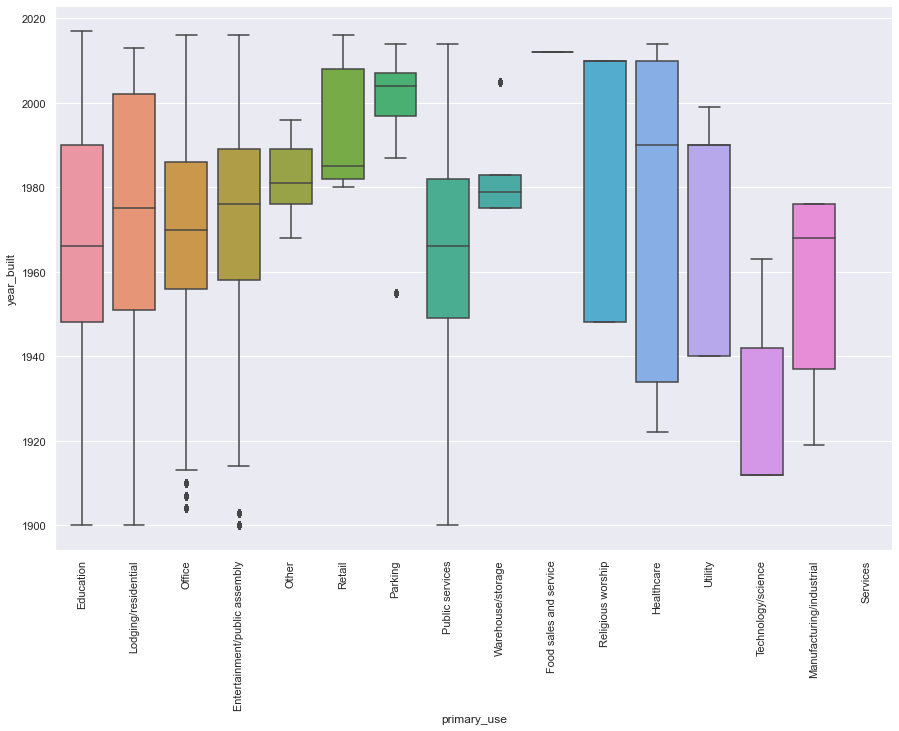

In [132]:
# usage of the building 과 the age of the building의 관계 비교
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x='primary_use', y='year_built', data=train)
plt.xticks(rotation=90);

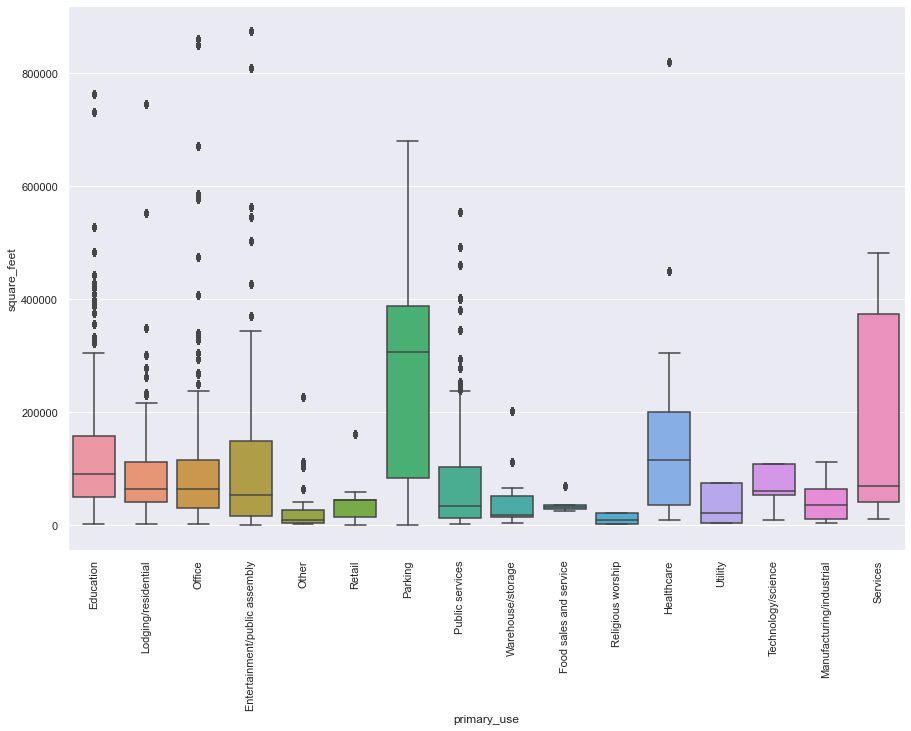

In [10]:
# building area 과 building types 사이의 비교
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x='primary_use', y='square_feet', data=train)
plt.xticks(rotation=90);

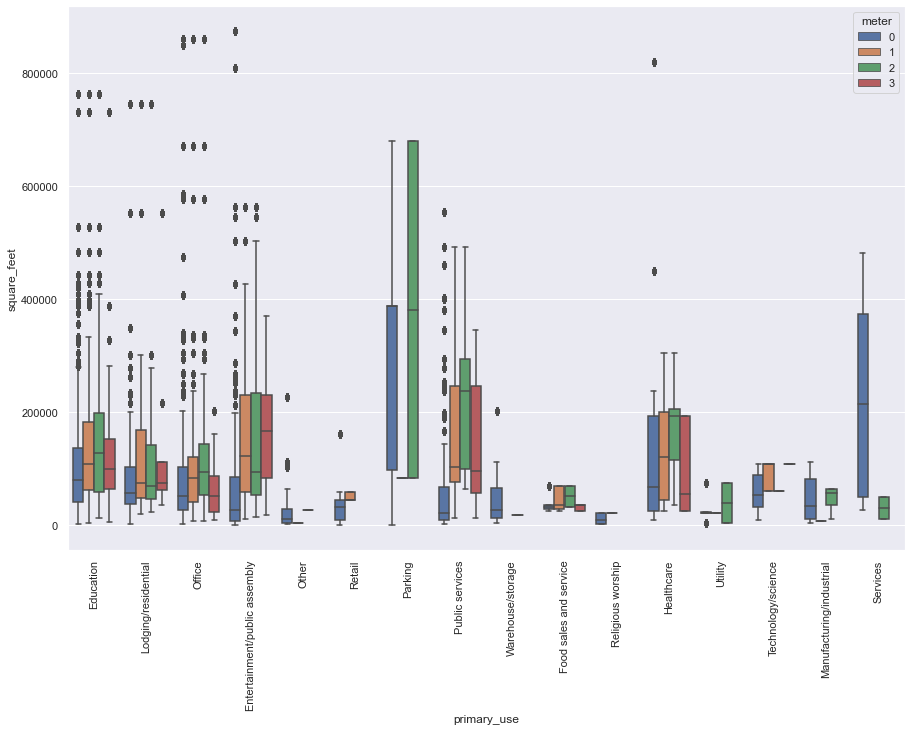

In [11]:
## different types of buildings 그리고 different types of meters 설치여부에 대한 비교
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x='primary_use', y='square_feet', hue='meter',data=train)
plt.xticks(rotation=90);

In [12]:
## 빌딩에 따라 2-3개 타입의 미터만 설치하기도함
sample=pd.DataFrame(train,columns=['site_id','primary_use'])
sample.drop_duplicates(keep='first')

,site_id,primary_use
0,0,Education
6,0,Lodging/residential
9,0,Office
10,0,Entertainment/public assembly
41,0,Other
...,...,...
2098,15,Manufacturing/industrial
2129,15,Religious worship
2139,15,Lodging/residential
2153,15,Utility


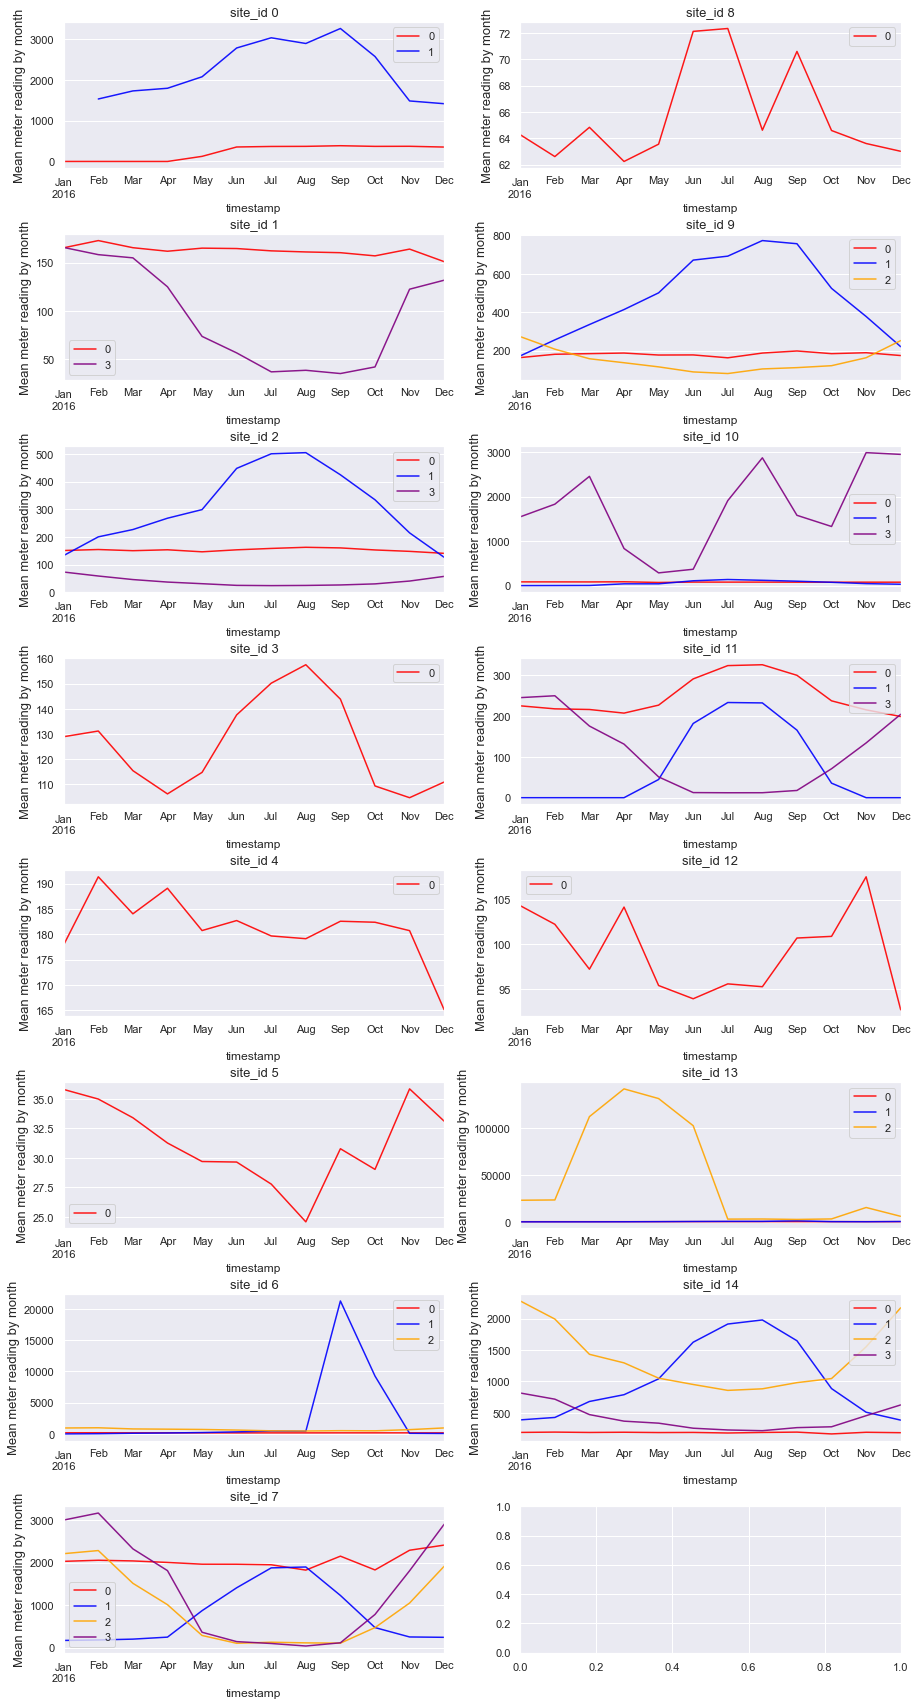

In [20]:
# by month
# meter type 과 site id 비교 - meter type 0: electricity, 1: chilledwater, 2: steam, 3: hotwater
# 지역에 따라 2-3 - 뜨거운 물이나 스팀- 사용량이 급감하기도 함

fig, axes = plt.subplots(8,2,figsize=(15, 30))
color_dic={'red':0,'blue':1,'orange':2,'purple':3}
for i in range(0,15):    
    for color,meter in color_dic.items():
        if(len(train[(train['site_id']==i)&(train['meter']==meter)])!=0):
            train[(train['site_id']==i)&(train['meter']==meter)][['timestamp', 'meter_reading']].set_index('timestamp').resample('M').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.9, label=str(meter), color=color).set_ylabel('Mean meter reading by month', fontsize=13)
        axes[i%8][i//8].legend();
        axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
        plt.subplots_adjust(hspace=0.45)

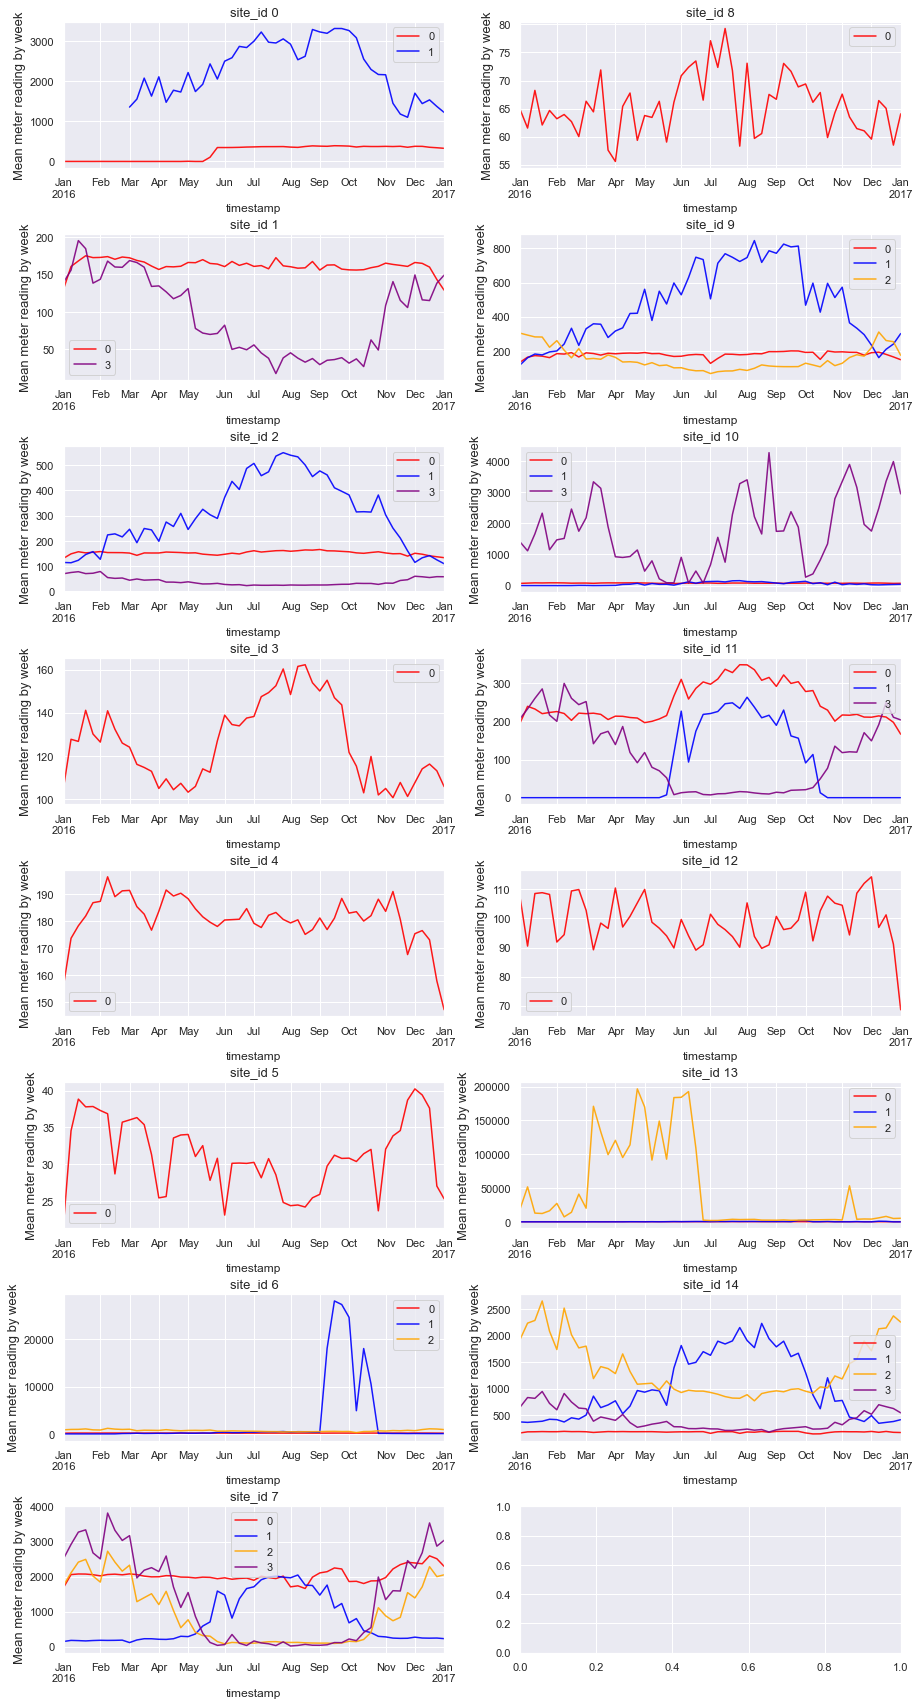

In [21]:
# by week 주별로 다시 나누어봄
fig, axes = plt.subplots(8,2,figsize=(15, 30))
color_dic={'red':0,'blue':1,'orange':2,'purple':3}
for i in range(0,15):    
    for color,meter in color_dic.items():
        if(len(train[(train['site_id']==i)&(train['meter']==meter)])!=0):
            train[(train['site_id']==i)&(train['meter']==meter)][['timestamp', 'meter_reading']].set_index('timestamp').resample('W').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.9, label=str(meter), color=color).set_ylabel('Mean meter reading by week', fontsize=13)
        axes[i%8][i//8].legend();
        axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
        plt.subplots_adjust(hspace=0.45)

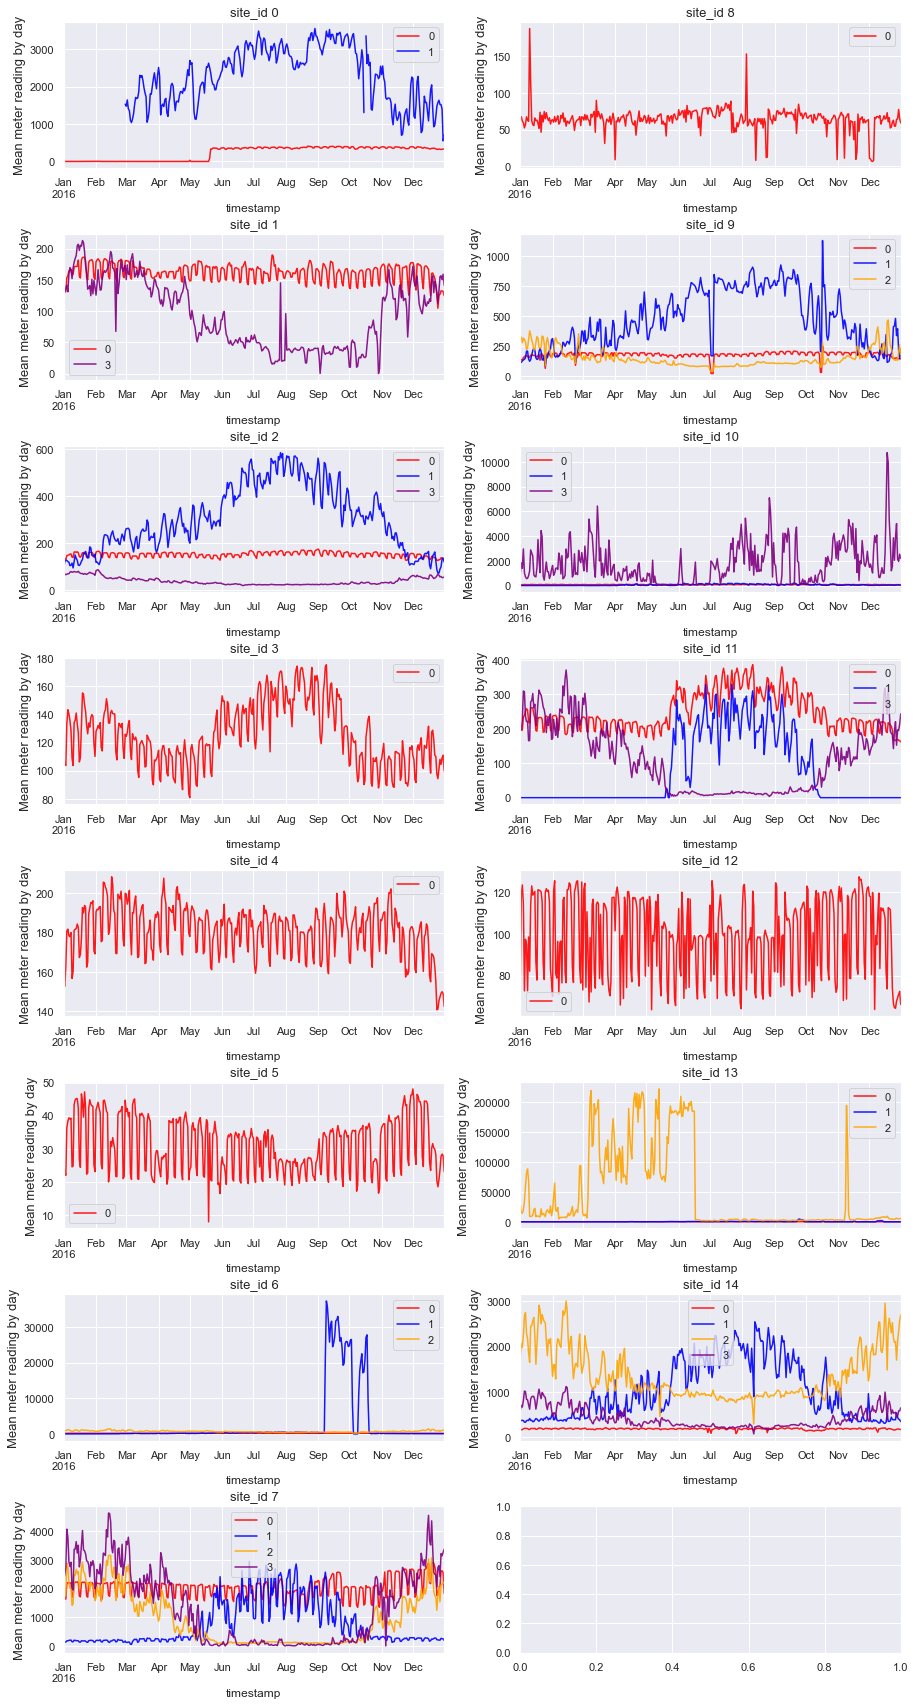

In [22]:
## 나아가 데이 뷰로 다시 나눠봄
# By day
fig, axes = plt.subplots(8,2,figsize=(15, 30))
color_dic={'red':0,'blue':1,'orange':2,'purple':3}
for i in range(0,15):    
    for color,meter in color_dic.items():
        if(len(train[(train['site_id']==i)&(train['meter']==meter)])!=0):
            train[(train['site_id']==i)&(train['meter']==meter)][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.9, label=str(meter), color=color).set_ylabel('Mean meter reading by day', fontsize=13)
        axes[i%8][i//8].legend();
        axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
        plt.subplots_adjust(hspace=0.45)

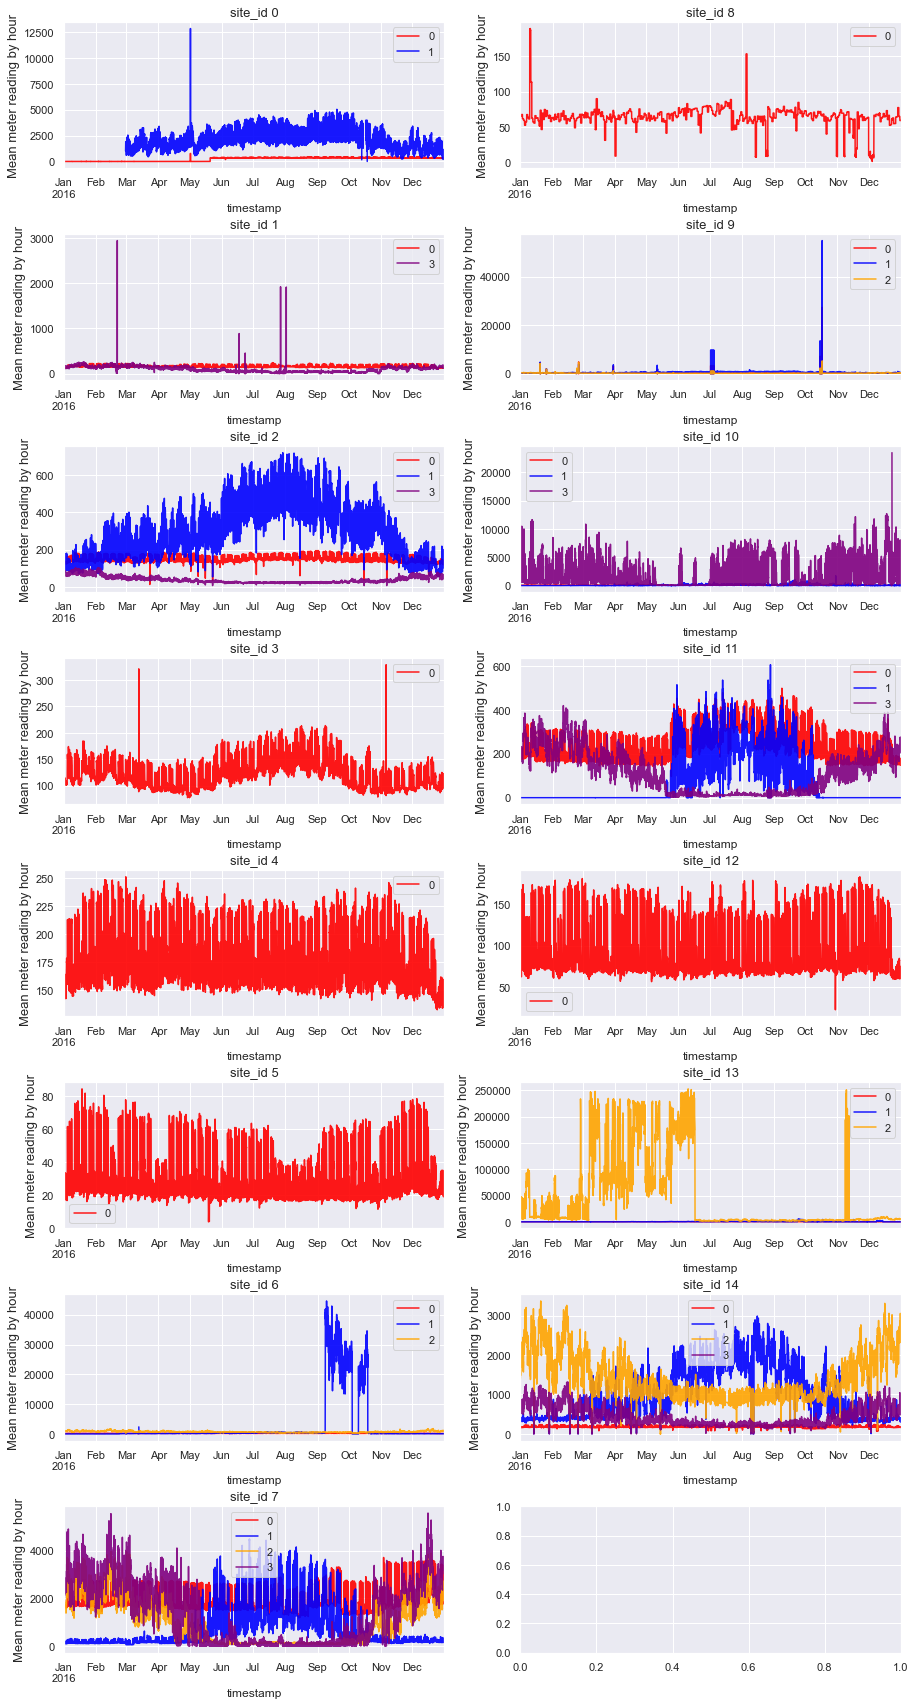

In [23]:
# By hour 시간으로 다시나눙
fig, axes = plt.subplots(8,2,figsize=(15, 30))
color_dic={'red':0,'blue':1,'orange':2,'purple':3}
for i in range(0,15):    
    for color,meter in color_dic.items():
        if(len(train[(train['site_id']==i)&(train['meter']==meter)])!=0):
            train[(train['site_id']==i)&(train['meter']==meter)][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], alpha=0.9, label=str(meter), color=color).set_ylabel('Mean meter reading by hour', fontsize=13)
        axes[i%8][i//8].legend();
        axes[i%8][i//8].set_title('site_id {}'.format(i), fontsize=13);
        plt.subplots_adjust(hspace=0.45)

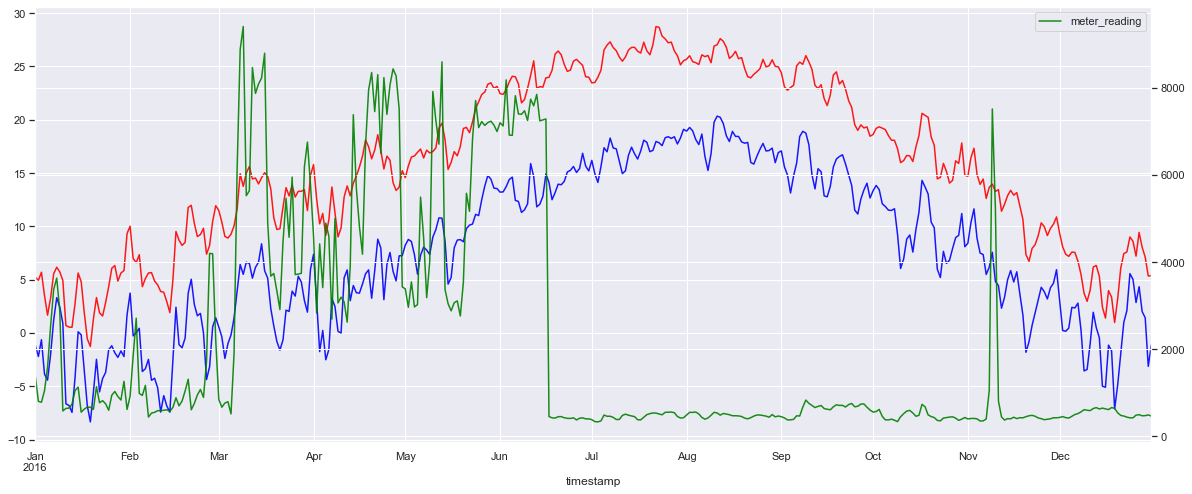

In [10]:
#기후와 상관관계
# the weather condition(by day)
fig, axes = plt.subplots(figsize=(20,8))
axes1=axes.twinx()
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes1,alpha=0.9, label='meter_reading', color='green')
train[['timestamp', 'air_temperature']].set_index('timestamp').resample('D').mean()['air_temperature'].plot(ax=axes,alpha=0.9, label='air_temperature', color='red')
train[['timestamp', 'dew_temperature']].set_index('timestamp').resample('D').mean()['dew_temperature'].plot(ax=axes,alpha=0.9, label='dew_temperature', color='blue')
plt.legend()

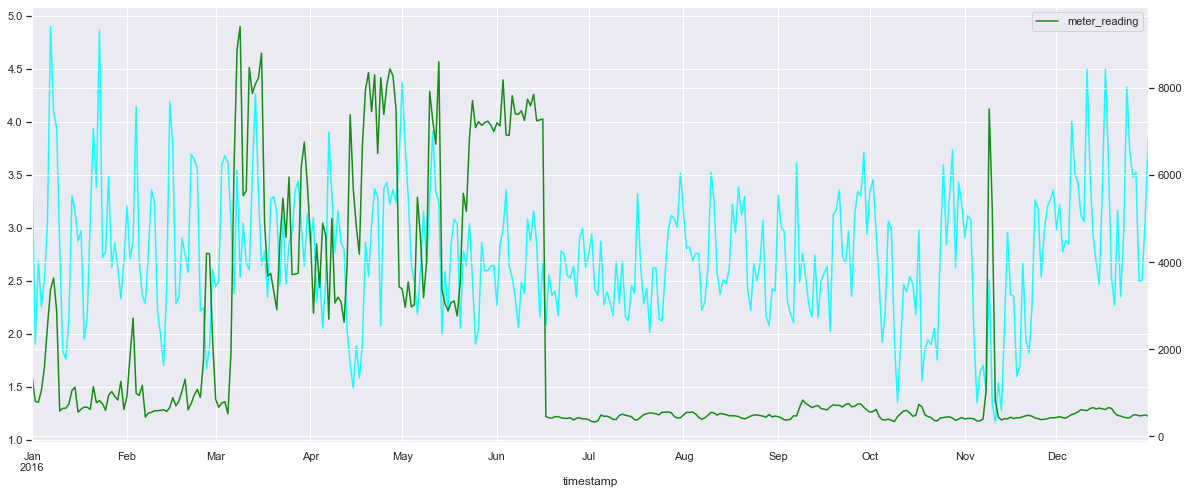

In [11]:
# the cloud condition(by day)
fig, axes = plt.subplots(figsize=(20,8))
axes1=axes.twinx()
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes1,alpha=0.9, label='meter_reading', color='green')
train[['timestamp', 'cloud_coverage']].set_index('timestamp').resample('D').mean()['cloud_coverage'].plot(ax=axes,alpha=0.9, label='cloud_coverage', color='cyan')
plt.legend()

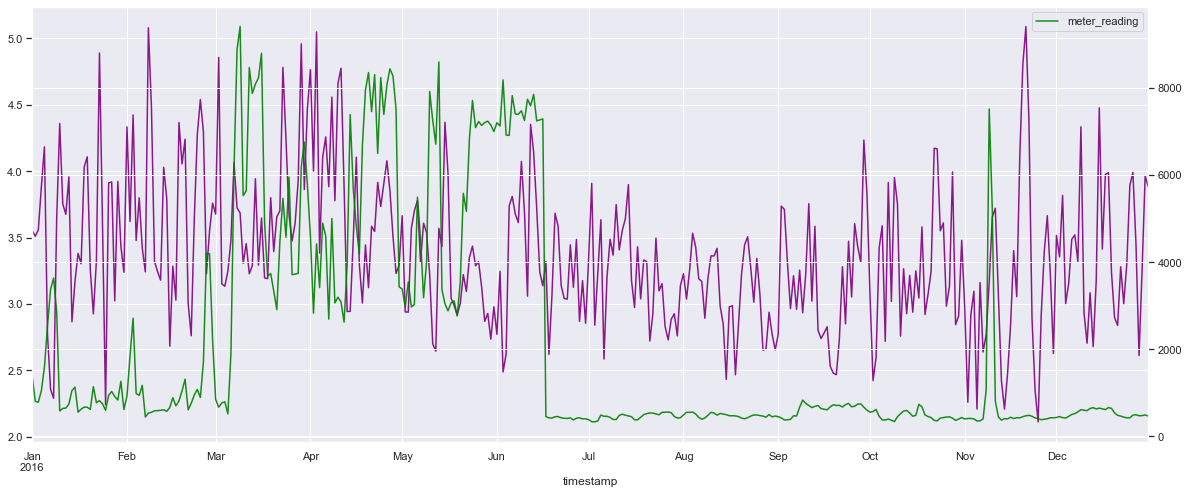

In [12]:
# the wind condition(by day)

fig, axes = plt.subplots(figsize=(20,8))
axes1=axes.twinx()
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes1,alpha=0.9, label='meter_reading', color='green')
train[['timestamp', 'wind_speed']].set_index('timestamp').resample('D').mean()['wind_speed'].plot(ax=axes,alpha=0.9, label='wind_speed', color='purple')
plt.legend()


<AxesSubplot:>

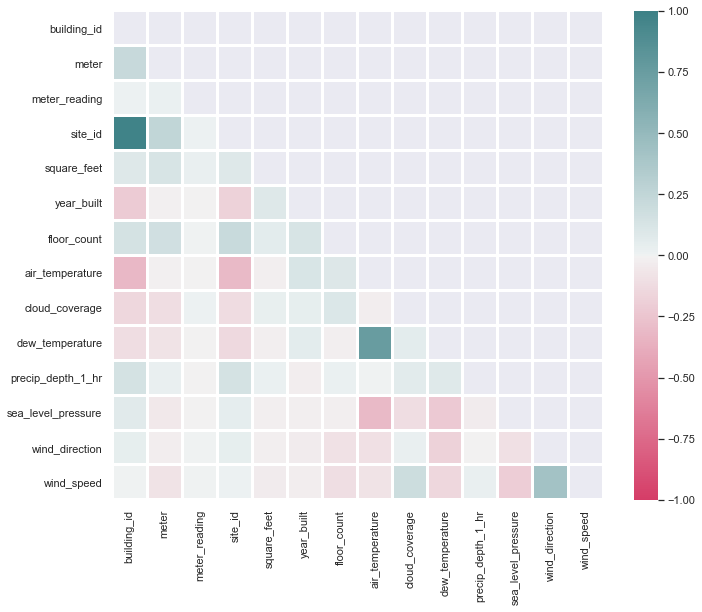

In [121]:
corr = train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(11,9))
cmap = sns.diverging_palette(1,200, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, linewidths=2)

<AxesSubplot:>

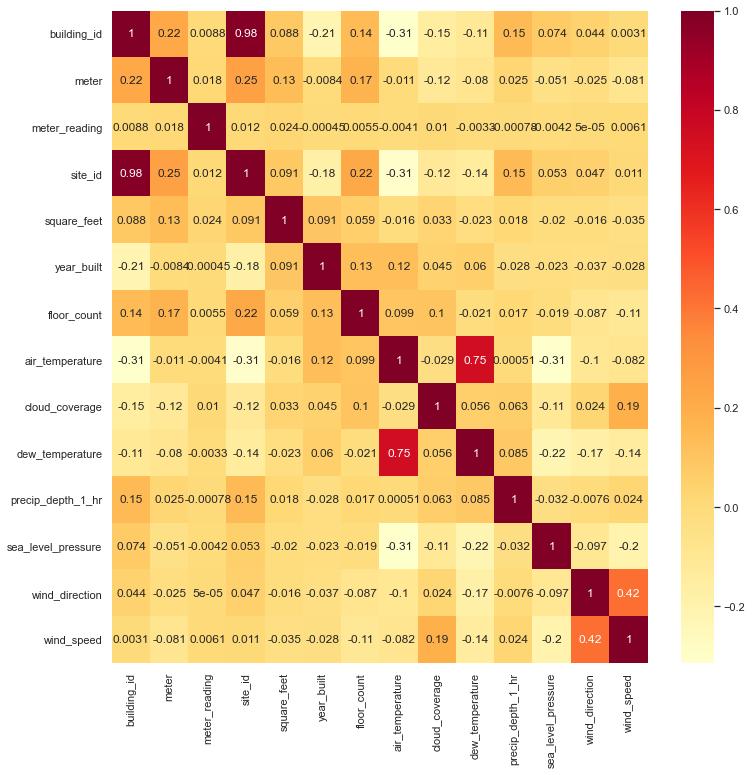

In [130]:
plt.figure(figsize=(12,12))
sns.heatmap(train.corr(), annot=True, cmap='YlOrRd')

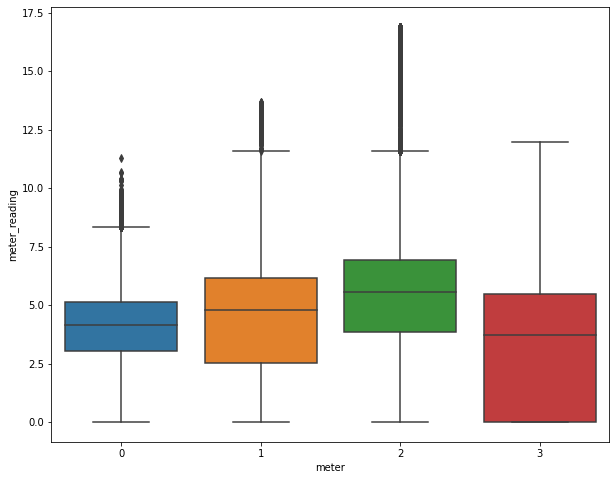

In [21]:
train['meter_reading'] = np.log1p(train['meter_reading'])
fig = plt.figure(figsize=(10, 8))
sns.boxplot(x='meter', y='meter_reading', data=train);

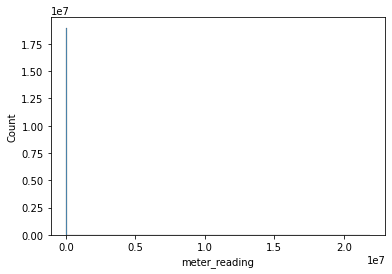

In [121]:
sns.histplot(x='meter_reading', data=train, bins=200);

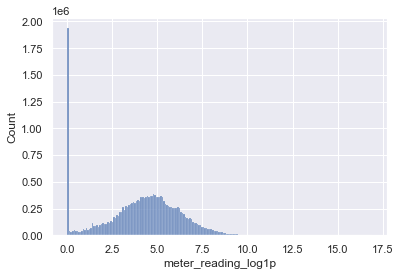

In [142]:
# 0에 근접한 값이 많아서 1을 더해서 log를 씌워주는 scaling 진행
train['meter_reading_log1p'] = np.log1p(train['meter_reading'])
sns.histplot(x='meter_reading_log1p', data=train, bins=200);

In [ ]:
# 교차분석
# from IPython.display import display
# pd.options.display.float_format = '{:,.1f}'.format

# pd.crosstab([train.Embarked, train.Sex], train.Pclass, margins=True, normalize="index") * 100

In [133]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 17 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         int16         
 1   meter               int8          
 2   timestamp           datetime64[ns]
 3   meter_reading       float32       
 4   site_id             int8          
 5   primary_use         object        
 6   square_feet         int32         
 7   year_built          float16       
 8   floor_count         int8          
 9   air_temperature     float16       
 10  cloud_coverage      float16       
 11  dew_temperature     float16       
 12  precip_depth_1_hr   float16       
 13  sea_level_pressure  float16       
 14  wind_direction      float16       
 15  wind_speed          float16       
 16  is_holiday          object        
dtypes: datetime64[ns](1), float16(8), float32(1), int16(1), int32(1), int8(3), object(2)
memory usage: 1.1+ GB


In [62]:
train.isna().sum()

building_id                0
meter                      0
timestamp                  0
meter_reading              0
site_id                    0
primary_use                0
square_feet                0
year_built                 0
floor_count                0
air_temperature        90495
cloud_coverage         90495
dew_temperature        90495
precip_depth_1_hr      90495
sea_level_pressure     90495
wind_direction         90495
wind_speed             90495
meter_reading_log1p        0
dtype: int64

In [186]:
# weather 파일에는 0시 데이터는 없고 1시 이후 데이터만 있어서 merge 후 결측치가 발생했던 것
weather_train = pd.read_csv('./ashrae-energy-prediction/weather_train.csv')

weather_train[weather_train['site_id']==4].head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
35110,4,2016-01-01 01:00:00,9.4,0.0,-2.2,0.0,1021.4,360.0,3.1
35111,4,2016-01-01 02:00:00,8.3,0.0,-2.8,0.0,1021.6,0.0,0.0
35112,4,2016-01-01 03:00:00,7.8,0.0,-2.8,0.0,1021.7,90.0,1.5
35113,4,2016-01-01 04:00:00,5.0,0.0,-0.6,0.0,1021.8,0.0,0.0
35114,4,2016-01-01 05:00:00,5.6,0.0,-1.1,0.0,1021.6,130.0,3.1


In [187]:
train[train['site_id']==4].head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
722,565,0,2016-01-01 00:00:00,7.250,4,Education,15326,1954.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
723,566,0,2016-01-01 00:00:00,0.519,4,Education,2010,1957.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
724,569,0,2016-01-01 00:00:00,246.000,4,Education,86091,1964.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
725,570,0,2016-01-01 00:00:00,79.488,4,Education,193202,1964.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
726,571,0,2016-01-01 00:00:00,17.000,4,Education,47954,1980.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
list_f = ['site_id', 'timestamp', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']

train[list_f] = train[list_f].groupby('site_id').apply(lambda x: x.bfill())
train[list_f] = train[list_f].groupby('site_id').apply(lambda x: x.ffill())

test[list_f] = test[list_f].groupby('site_id').apply(lambda x: x.bfill())
test[list_f] = test[list_f].groupby('site_id').apply(lambda x: x.ffill())

train.isna().sum()

building_id           0
meter                 0
timestamp             0
meter_reading         0
site_id               0
primary_use           0
square_feet           0
year_built            0
floor_count           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

In [64]:
train[train['site_id']==4].head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading_log1p
722,565,0,2016-01-01 00:00:00,7.250,4,Education,15326,1954.0,0,9.4,0.0,-2.2,0.0,1021.4,360.0,3.1,2.110213
723,566,0,2016-01-01 00:00:00,0.519,4,Education,2010,1957.0,0,9.4,0.0,-2.2,0.0,1021.4,360.0,3.1,0.418052
724,569,0,2016-01-01 00:00:00,246.000,4,Education,86091,1964.0,0,9.4,0.0,-2.2,0.0,1021.4,360.0,3.1,5.509388
725,570,0,2016-01-01 00:00:00,79.488,4,Education,193202,1964.0,0,9.4,0.0,-2.2,0.0,1021.4,360.0,3.1,4.388108
726,571,0,2016-01-01 00:00:00,17.000,4,Education,47954,1980.0,0,9.4,0.0,-2.2,0.0,1021.4,360.0,3.1,2.890372


In [15]:
# train.drop(train.columns[9:], axis=1, inplace=True)
# test.drop(test.columns[9:], axis=1, inplace=True)
# train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN


In [16]:
# merge train_df = train.merge(train_draft, on=['timestamp', 'site_id'], how='left')로 하면 row가 늘어나는 이유? 

# train_draft.drop(['site_id', 'timestamp'], axis=1, inplace=True)

# train = pd.concat([train, train_draft], axis=1, join='inner')
# test = pd.concat([test, test_draft], axis=1, join='inner')

# del train_draft, test_draft

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,0.0,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,0.0,1019.7,0.0,0.0


In [122]:
# groupby('').isna(mean()).apply(lambdax:x.mean())으로 간단하게 바꾸기
# def imputation_mean(df, col):
#     temp = df.groupby('building_id').mean()[col]
#     temp.name = 'temp'
#     df = df.merge(temp, on='building_id')
#     df.loc[df[col].isna(), col] = df[df[col].isna()][[col]].apply(lambda x: df['temp'][x.index].values)
#     del temp, df['temp']
#     return df

In [ ]:
# train = imputation_mean(train, 'air_temperature')
# train = imputation_mean(train, 'cloud_coverage')
# train = imputation_mean(train, 'dew_temperature')
# train = imputation_mean(train, 'precip_depth_1_hr')
# train = imputation_mean(train, 'sea_level_pressure')
# train = imputation_mean(train, 'wind_direction')
# train = imputation_mean(train, 'wind_speed')

# test = imputation_mean(test, 'air_temperature')
# test = imputation_mean(test, 'cloud_coverage')
# test = imputation_mean(test, 'dew_temperature')
# test = imputation_mean(test, 'precip_depth_1_hr')
# test = imputation_mean(test, 'sea_level_pressure')
# test = imputation_mean(test, 'wind_direction')
# test = imputation_mean(test, 'wind_speed')

In [61]:
train['primary_use'].value_counts()

Education                        8165504
Office                           4394864
Entertainment/public assembly    2264917
Lodging/residential              2146413
Public services                  1662826
Healthcare                        398527
Other                             242222
Parking                           213796
Manufacturing/industrial          125713
Food sales and service            114090
Retail                            112657
Warehouse/storage                 111861
Services                           96519
Technology/science                 77627
Utility                            56203
Religious worship                  32361
Name: primary_use, dtype: int64

In [144]:
train['wind_direction'].value_counts()

0.000000      2463728
170.000000     689701
300.000000     642796
180.000000     611260
290.000000     600173
               ...   
139.230769         47
42.307692          47
85.384615          47
156.666667         46
106.923077         45
Name: wind_direction, Length: 543, dtype: int64

In [79]:
# def imputation_mean(df, col):
#     imputation = df.groupby(['timestamp'])[col].mean()
#     df.loc[df[col].isna(), col] = df[df[col].isna()][[col]].apply(lambda x: imputation[df['timestamp'][x.index]].values)
#     del imputation
#     return df

In [21]:
def Compass(num): # 345도~15도 카테고리12
    val = num/30  # 360/12 = 30
    if val == 0.5:
        val = 1
        return val
    elif val == int(val)+0.5:
        val = int(val)+1
        return val
    elif val < 0.5:
        val = 12
        return val
    else:
        return round(val)

In [22]:
train['wind_direction'] = train['wind_direction'].apply(Compass)
test['wind_direction'] = test['wind_direction'].apply(Compass)

In [23]:
# 15도를 기점으로 30도씩 나눠서 총 12개 카테고리(예: 345도~15도 카테고리12)

train['wind_direction'].value_counts()

12    3760522
6     2038899
10    1853856
5     1675107
9     1616902
11    1580462
7     1454811
3     1397883
4     1357501
8     1270558
2     1180323
1     1029276
Name: wind_direction, dtype: int64

In [23]:
# 데이터는 풍부한 것이 좋으므로 이렇게 해주는 것이 오히려 안좋은지?
# m/s 기준 보퍼트 풍력계급

beaufort = [(0, 0, 0.3), (1, 0.3, 1.5), (2, 1.5, 3.3), (3, 3.3, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
          (7, 13.9, 17.2), (8, 17.2, 20.7), (9, 20.7, 24.5), (10, 24.5, 28.4), (11, 28.5, 32.6), (12, 32.6, 100)]

In [24]:
for i in beaufort:
    train.loc[(train['wind_speed']>=i[1]) & (train['wind_speed']<i[2]), 'beaufort_scale'] = i[0]
train['beaufort_scale'].value_counts()

2.0    8720973
3.0    5532443
4.0    2648645
0.0    2392514
5.0     644565
1.0     134318
6.0     127674
7.0      14600
8.0        368
Name: beaufort_scale, dtype: int64

In [25]:
for i in beaufort:
    test.loc[(test['wind_speed']>=i[1]) & (test['wind_speed']<i[2]), 'beaufort_scale'] = i[0]
test['beaufort_scale'].value_counts()

2.0    17892815
3.0    11745361
4.0     5489611
0.0     4826836
5.0     1245346
6.0      237029
1.0      233801
7.0       22877
8.0        2966
9.0         958
Name: beaufort_scale, dtype: int64

In [87]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading_log1p,beaufort_scale
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,1,25.0,6.0,20.0,0.0,1019.5,12,0.0,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,1,25.0,6.0,20.0,0.0,1019.5,12,0.0,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,1,25.0,6.0,20.0,0.0,1019.5,12,0.0,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,1,25.0,6.0,20.0,0.0,1019.5,12,0.0,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,1,25.0,6.0,20.0,0.0,1019.5,12,0.0,0.0,0.0


In [26]:
# datetime형으로 바꾸기

train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

In [27]:
# 새로운 피쳐1. 미국 주요 스포츠 경기일자

gameday = ['2016-02-07', '2016-10-25', '2016-10-26', '2016-10-28', '2016-10-29', '2016-10-30', '2016-11-01', 
           '2016-11-02', '2016-11-08', '2016-08-03', '2016-08-06', '2016-08-07', '2016-08-08', '2016-08-09', 
           '2016-08-10', '2016-08-11', '2016-08-12', '2016-08-13', '2016-08-15', '2016-08-16', '2016-08-12', 
           '2016-08-13', '2016-08-14', '2016-08-15', '2016-08-16', '2016-08-17', '2016-08-18', '2016-08-19',
           '2016-08-20', '2016-08-21', '2016-05-28']

for i in gameday:
    train.loc[(train['timestamp']==i), 'is_gameday'] = 1
train['is_gameday'] = train['is_gameday'].fillna(0)

for i in gameday:
    test.loc[(test['timestamp']==i), 'is_gameday'] = 1
test['is_gameday'] = test['is_gameday'].fillna(0)

In [44]:
train.sample(5)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,beaufort_scale,is_holiday,is_gameday
11602969,307,0,2016-07-31 09:00:00,21.1500,3,Public services,10873,NaN,1,23.9,4.0,22.2,0.0,1014.3,11,2.1,2.0,False,0.0
765227,1163,1,2016-01-14 21:00:00,3.9359,13,Parking,83919,NaN,1,-3.9,8.0,-6.7,0.0,998.9,4,5.1,3.0,False,0.0
11721234,203,0,2016-08-02 12:00:00,327.5000,2,Lodging/residential,63348,2007.0,1,30.6,6.0,20.6,0.0,1011.0,5,3.1,2.0,False,0.0
3595776,168,1,2016-03-08 19:00:00,625.7180,2,Education,183460,2005.0,1,16.7,4.0,1.1,0.0,1008.7,9,3.6,3.0,False,0.0
3615949,1003,0,2016-03-09 04:00:00,68.2500,10,Education,94751,NaN,0,4.4,2.0,-3.3,0.0,1012.1,7,2.6,2.0,False,0.0


In [28]:
# 새로운 피쳐2. 휴일 컬럼 생성(휴일에 속하면 True, 아니면 False)

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

dates_range = pd.date_range(start='2015-12-31', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())
train['is_holiday'] = (train['timestamp'].dt.date.astype('datetime64').isin(us_holidays))
test['is_holiday'] = (test['timestamp'].dt.date.astype('datetime64').isin(us_holidays))

In [29]:
# 새로운 피쳐3

train['month'] = train['timestamp'].dt.month
train['hour'] = train['timestamp'].dt.hour  # 3시간 단위로 나누기(category)
train['dayofweek'] = train['timestamp'].dt.dayofweek
train['day'] = train['timestamp'].dt.day
train['weekofmonth'] = train['timestamp'].dt.day/7
train['weekofmonth'] = train['weekofmonth'].apply(lambda x: math.ceil(x))

test['month'] = test['timestamp'].dt.month
test['hour'] = test['timestamp'].dt.hour
test['dayofweek'] = test['timestamp'].dt.dayofweek
test['day'] = test['timestamp'].dt.day
test['weekofmonth'] = test['timestamp'].dt.day/7
test['weekofmonth'] = test['weekofmonth'].apply(lambda x: math.ceil(x))

In [30]:
def hours(num):
    val = math.ceil(float(num/3))
    if val == 0:
        val = 1
    return val

In [31]:
train['hour'] = train['hour'].apply(hours)
test['hour'] = test['hour'].apply(hours)

In [193]:
train['hour'].value_counts() # 1~3시 카테고리1

1    3367154
6    2528041
7    2528007
5    2527156
4    2527021
2    2526959
3    2526387
8    1685375
Name: hour, dtype: int64

In [17]:
train['year'] = train['timestamp'].dt.year
train['year'].value_counts()

2016    20216100
Name: year, dtype: int64

In [12]:
test['year'] = test['timestamp'].dt.year
test['year'].value_counts()

2017    20848800
2018    20848800
Name: year, dtype: int64

In [93]:
# year_built가 NaN이면 같은 building_id를 쓰는 건물들의 year_built 모두 NaN
# ids = train[train['year_built'].isna()]['building_id'].unique()
# for i in ids:
#     if (train[train['building_id'] == 105]['year_built'].isna().sum() / len(train[train['building_id'] == 105])) < 1:
#         print(i)

In [96]:
train.sample(7)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading_log1p,beaufort_scale,is_holiday,month,hour,dayofweek,day,weekofmonth
11883399,146,0,2016-08-05 10:00:00,11.400000,1,Office,31614,1956.0,0,20.000000,0.0,10.500000,0.960449,1020.5,8,4.101562,2.517578,3.0,False,8,4,4,5,1
3070624,211,0,2016-02-27 08:00:00,161.199997,2,Education,48411,1974.0,1,18.296875,0.0,0.000000,0.000000,1015.0,4,2.599609,5.089844,2.0,False,2,3,5,27,4
170068,2,0,2016-01-04 02:00:00,0.000000,0,Education,5376,1991.0,1,11.101562,8.0,10.000000,5.000000,1016.5,11,4.101562,0.000000,3.0,False,1,1,0,4,1
11594628,1022,3,2016-07-31 05:00:00,0.000000,10,Education,84346,1965.0,0,28.296875,0.0,7.199219,0.000000,1006.5,3,2.099609,0.000000,2.0,False,7,2,6,31,5
11801393,1118,0,2016-08-03 22:00:00,22.313000,13,Services,26926,1965.0,1,31.703125,4.0,21.703125,0.000000,1013.5,6,4.601562,3.148438,3.0,False,8,8,2,3,1
13434650,625,0,2016-09-02 08:00:00,213.832001,4,Education,55516,1978.0,0,16.093750,0.0,12.796875,0.000000,1013.5,7,1.500000,5.371094,2.0,False,9,3,4,2,1
10110422,1191,1,2016-07-04 18:00:00,1439.420044,13,Education,192152,1965.0,1,24.406250,6.0,13.898438,0.000000,1009.0,6,5.699219,7.273438,4.0,True,7,6,0,4,1


In [274]:
list_a = ['building_id','month', 'hour', 'dayofweek', 'weekofmonth']
train[list_a].sample(7)

,building_id,month,hour,dayofweek,weekofmonth
16312967,189,10,3,6,4
9178878,728,6,2,5,3
15475045,1198,10,4,5,2
9490632,510,6,6,3,4
15110579,801,10,1,6,1
11740191,493,8,7,1,1
17011278,693,11,6,4,1


In [267]:
# train.dropna(subset=['sea_level_pressure'])
# train.dropna(subset=['dew_temperature'])
# train.dropna(subset=['air_temperature'])
# train.drop(['floor_count', 'timestamp', 'wind_speed'], axis=1, inplace=True)

In [124]:
# 0: electricity, 1: chilledwater, 2: steam, 3: hotwater

# train.groupby(['meter'])['meter_reading'].agg(['min','max','mean','median','count','std'])

,min,max,mean,median,count,std
meter,,,,,,
0,0.0,11.286902,4.074908,4.254193,11041084,1.688704
1,0.0,13.688104,4.261568,4.822988,4076572,2.533907
2,0.0,16.902212,5.113881,5.549854,2614274,2.647327
3,0.0,11.984103,3.314197,3.666102,1249382,2.603041


In [125]:
# train.groupby(['meter','month'])['meter_reading'].agg(['max','mean','median','count','std'])
# train.groupby(['timestamp']).agg(['min','max','mean', 'median'])['wind_direction'] # 데이터 자체는 풍성할수록 좋음
# train.groupby(['building_id'])['cloud_coverage'].agg(['min','max','mean', 'median'])
# train.groupby(['building_id'])['precip_depth_1_hr'].agg(['min','max','mean', 'median'])

max      mean    median   count       std
meter month                                                 
0     1      10.289838  3.799901  4.101403  920401  1.854292
      2      10.137610  3.812646  4.142023  835518  1.881916
      3      10.699586  3.769467  4.060443  880640  1.867711
      4       8.774910  3.820178  4.091257  919453  1.825582
      5       9.148784  3.930021  4.135167  948562  1.748119
      6       9.091219  4.243995  4.333099  916749  1.549967
      7       9.878785  4.238749  4.365316  946483  1.603620
      8       9.239511  4.338979  4.442651  935203  1.524519
      9       8.974099  4.319347  4.428731  927984  1.537894
      10     11.286902  4.143666  4.283587  952305  1.631912
      11      9.770133  4.235749  4.330733  920548  1.517412
      12      9.798127  4.198095  4.287853  937238  1.519254
1     1      10.249627  2.909498  3.237788  316166  2.385720
      2       9.980569  3.297070  3.895503  284952  2.484768
      3      10.768773  3.839506  4.488241  317205  2.607842
      4       9.942444  3.976268  4.560942  348074  2.522862
      5      12.058802  4.570653  5.044347  360909  2.337308
      6      10.296901  5.216850  5.623527  346000  2.157423
      7      11.359278  5.281142  5.731396  361480  2.238861
      8      11.169133  5.451823  5.848174  341917  2.152740
      9      13.688104  5.154390  5.591807  345299  2.262661
      10     13.482828  4.235110  4.843793  355295  2.528596
      11     12.761382  3.754450  4.296566  342160  2.464269
      12     12.198489  3.120544  3.422535  357115  2.470930
2     1      15.924924  6.119515  6.491937  212835  2.463187
      2      16.830664  5.964157  6.269889  184977  2.435955
      3      16.893946  5.491576  5.821417  185885  2.575952
      4      16.831707  5.376830  5.781669  221517  2.518747
      5      16.812862  4.791697  5.209868  230179  2.604005
      6      16.902212  4.314521  4.679814  219224  2.705281
      7      11.749980  4.141547  4.562588  231175  2.706755
      8      11.787720  4.300861  4.679814  226949  2.640229
      9      11.561726  4.498634  4.892235  224243  2.604496
      10     11.215206  4.796270  5.324716  229187  2.713502
      11     16.899616  5.601885  5.939697  222757  2.330170
      12     11.589896  6.271972  6.536719  225346  2.156878
3     1      11.597266  4.617193  4.974006  105298  2.295990
      2      11.253197  4.382994  4.736198   98032  2.386466
      3      11.662052  3.884894  4.262680  104756  2.440520
      4      11.273017  3.420830  3.868936  103078  2.528079
      5      10.807157  2.963697  3.154325  105465  2.516709
      6      11.185686  2.554181  2.281576  102187  2.470529
      7      11.379937  2.433800  1.925912  106182  2.492793
      8      11.403510  2.361102  1.925912  105799  2.472556
      9      11.368110  2.557123  2.137604  103371  2.543340
      10     11.301654  2.767128  2.750701  106443  2.600105
      11     11.630833  3.670964  4.163278  103354  2.567604
      12     11.984103  4.223075  4.611590  105417  2.451962

In [ ]:
# iqr = train[train['meter'] == 0]['meter_reading'].quantile(0.75)-train[train['meter'] == 2]['meter_reading'].quantile(0.25)
# q3 = train[train['meter'] == 0]['meter_reading'].quantile(0.75)
# q1 = train[train['meter'] == 0]['meter_reading'].quantile(0.25)

# outlier_range_meter_2 = (q1-1.5*iqr,q3+1.5*iqr)
# outlier_range_meter_2

In [ ]:
# iqr = train[train['meter'] == 1]['meter_reading'].quantile(0.75)-train[train['meter'] == 2]['meter_reading'].quantile(0.25)
# q3 = train[train['meter'] == 1]['meter_reading'].quantile(0.75)
# q1 = train[train['meter'] == 1]['meter_reading'].quantile(0.25)

# outlier_range_meter_2 = (q1-1.5*iqr,q3+1.5*iqr)
# outlier_range_meter_2

In [129]:
# iqr = train[train['meter'] == 2]['meter_reading'].quantile(0.75)-train[train['meter'] == 2]['meter_reading'].quantile(0.25)
# q3 = train[train['meter'] == 2]['meter_reading'].quantile(0.75)
# q1 = train[train['meter'] == 2]['meter_reading'].quantile(0.25)

# outlier_range_meter_2 = (q1-1.5*iqr,q3+1.5*iqr)
# outlier_range_meter_2

(-0.7990236282348633, 11.58454418182373)

In [130]:
# train.drop(train[(train['meter'] == 0) & (train['meter_reading'] < 1.12) & (train['meter_reading'] > 7.24)].index, inplace=True)
# train.drop(train[(train['meter'] == 1) & (train['meter_reading'] > 9.62)].index, inplace=True)
# train.drop(train[(train['meter'] == 2) & (train['meter_reading'] > 11.585)].index, inplace=True)

In [81]:
total = train.isna().sum().sort_values(ascending = False)
percent = (train.isna().sum()/train.shape[0]*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head(10)

,Total,Percent
building_id,0,0.0
meter,0,0.0
day,0,0.0
dayofweek,0,0.0
hour,0,0.0
month,0,0.0
is_holiday,0,0.0
is_gameday,0,0.0
beaufort_scale,0,0.0
wind_speed,0,0.0


In [32]:
# 메모리 줄이기

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 1195.33 Mb (67.2% reduction)
Mem. usage decreased to 2465.49 Mb (67.2% reduction)


In [263]:
# train = train.dropna()

In [80]:
train.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'beaufort_scale', 'is_gameday', 'is_holiday', 'month',
       'hour', 'dayofweek', 'day', 'weekofmonth'],
      dtype='object')

In [103]:
test.columns

Index(['row_id', 'building_id', 'meter', 'timestamp', 'site_id', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'beaufort_scale',
       'is_holiday', 'month', 'hour', 'dayofweek', 'day', 'weekofmonth'],
      dtype='object')

In [83]:
train['building_id'].value_counts()

1249    35136
1298    35136
1301    35128
1241    35116
1296    35115
        ...  
783      2657
420      2327
53       1685
604      1012
403       479
Name: building_id, Length: 1449, dtype: int64

In [33]:
list_cat = [
    'meter', 'site_id', 'primary_use', 'floor_count', 'wind_direction', 'month', 'hour',
    'dayofweek', 'day', 'weekofmonth', 'beaufort_scale', 'is_holiday', 'is_gameday'
]
train[list_cat] = train[list_cat].astype(str)

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 23 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         int64         
 1   meter               object        
 2   timestamp           datetime64[ns]
 3   meter_reading       float64       
 4   site_id             object        
 5   primary_use         object        
 6   square_feet         int64         
 7   year_built          float64       
 8   floor_count         object        
 9   air_temperature     float64       
 10  cloud_coverage      float64       
 11  dew_temperature     float64       
 12  precip_depth_1_hr   float64       
 13  sea_level_pressure  float64       
 14  wind_direction      object        
 15  wind_speed          float64       
 16  beaufort_scale      object        
 17  is_holiday          object        
 18  month               object        
 19  hour                object        
 20  

In [ ]:
X_num = train[[
    'square_feet', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_speed',
    'year_built'
]]
    
# scaler = StandardScaler()
# scaler.fit(X_num)
# X_scaled = scaler.transform(X_num)
# X_scaled = pd.DataFrame(X_scaled, index=X_num.index, columns=X_num.columns)

X_cat = train[[
    'meter', 'site_id', 'primary_use', 'floor_count', 'wind_direction', 'month', 'hour',
    'dayofweek', 'day', 'weekofmonth', 'beaufort_scale', 'is_holiday', 'is_gameday'
]]
X_cat = pd.get_dummies(X_cat, columns=list_cat, drop_first=True)

X_train = pd.concat([X_num, X_cat], axis=1)
y_train = train['meter_reading']

In [85]:
train_sample = train.sample(200000)

X_num = train_sample[[
    'square_feet', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_speed',
    'year_built'
]]
    
X_cat = train_sample[[
    'meter', 'site_id', 'primary_use', 'floor_count', 'wind_direction', 'month', 'hour',
    'dayofweek', 'day', 'weekofmonth', 'beaufort_scale', 'is_holiday', 'is_gameday'
]]
X_cat = pd.get_dummies(X_cat, columns=list_cat, drop_first=True)

X_train = pd.concat([X_num, X_cat], axis=1)
y_train = train_sample['meter_reading']

In [86]:
pd.set_option('display.max_columns', 999)
X_train.head()

,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,year_built,meter_1,meter_2,meter_3,site_id_1,site_id_10,site_id_11,site_id_12,site_id_13,site_id_14,site_id_15,site_id_2,site_id_3,site_id_4,site_id_5,site_id_6,site_id_7,site_id_8,site_id_9,primary_use_Entertainment/public assembly,primary_use_Food sales and service,primary_use_Healthcare,primary_use_Lodging/residential,primary_use_Manufacturing/industrial,primary_use_Office,primary_use_Other,primary_use_Parking,primary_use_Public services,primary_use_Religious worship,primary_use_Retail,primary_use_Services,primary_use_Technology/science,primary_use_Utility,primary_use_Warehouse/storage,floor_count_1,wind_direction_10,wind_direction_11,wind_direction_12,wind_direction_2,wind_direction_3,wind_direction_4,wind_direction_5,wind_direction_6,wind_direction_7,wind_direction_8,wind_direction_9,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_2,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_3,day_30,day_31,day_4,day_5,day_6,day_7,day_8,day_9,weekofmonth_2,weekofmonth_3,weekofmonth_4,weekofmonth_5,beaufort_scale_1.0,beaufort_scale_2.0,beaufort_scale_3.0,beaufort_scale_4.0,beaufort_scale_5.0,beaufort_scale_6.0,beaufort_scale_7.0,beaufort_scale_8.0,is_holiday_True
14268483,28406,10.3,6.0,8.5,4.321092,1024.5,4.0,1965.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
15407535,254766,24.4,0.0,4.4,0.000000,1010.0,2.6,1989.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4007714,77469,29.4,2.0,-10.0,0.000000,1009.4,0.0,1973.5,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2927326,40085,5.3,0.0,-0.1,0.842226,1018.5,1.0,1960.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
15505162,39648,27.8,0.0,16.7,0.000000,1019.9,2.1,1965.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.metrics import classification_report
from math import sqrt


x = [20000, 200000, 2000000, 5000000, 20000000]
y = []

no = 1
for i in [20000, 200000, 2000000, 5000000, 20000000]:
    train_sample = train.sample(i)

    X_num = train_sample[[
        'square_feet', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_speed',
        'year_built'
    ]]

    X_cat = train_sample[[
        'meter', 'site_id', 'primary_use', 'floor_count', 'wind_direction', 'month', 'hour',
        'dayofweek', 'day', 'weekofmonth', 'beaufort_scale', 'is_holiday', 'is_gameday'
    ]]
    X_cat = pd.get_dummies(X_cat, columns=list_cat, drop_first=True)

    X_train = pd.concat([X_num, X_cat], axis=1)
    y_train = train_sample['meter_reading']

    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=100)

    DTR = DecisionTreeRegressor(max_depth=4)
    DTR.fit(X_train, y_train)

    pred = DTR.predict(X_test)
    print(no, "train set", f"{i}")
    no += 1

    print(sqrt(mean_squared_log_error(y_test, pred)))
    print(sqrt(mean_squared_error(y_test, pred)))
    print("=============================================")

    y.append(round(sqrt(mean_squared_log_error(y_test, pred)), 4))

1 train set 20000
2.4381022471814466
327515.10145040933
2 train set 200000
2.4508013759583167
156322.63083405612
3 train set 2000000
2.402952820685947
121880.72097887465
4 train set 5000000
2.411066190880456
116311.50149997824
5 train set 20000000
2.4108395818114943
122140.75786549438


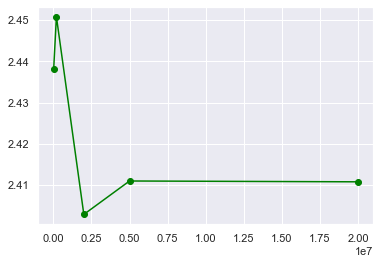

In [2]:
x = [20000, 200000, 2000000, 5000000, 20000000]
y = [2.43810, 2.4508, 2.4029, 2.4110, 2.4108]

plt.plot(x, y, color='green', marker='o')
plt.show()

In [89]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.metrics import classification_report
from math import sqrt

In [78]:
# train셋: 2만개

DTR = DecisionTreeRegressor(max_depth=4)
DTR.fit(X_train, y_train)

pred = DTR.predict(X_test)

print(sqrt(mean_squared_log_error(y_test, pred)))
print(sqrt(mean_squared_error(y_test, pred)))

2.497508463341934
1517.5796759453358


In [87]:
# train셋: 2십만개

DTR = DecisionTreeRegressor(max_depth=4)
DTR.fit(X_train, y_train)

pred = DTR.predict(X_test)

print(sqrt(mean_squared_log_error(y_test, pred)))
print(sqrt(mean_squared_error(y_test, pred)))

2.3989872923341906
148323.27361056634


In [90]:
# train셋: 2백만개

DTR = DecisionTreeRegressor(max_depth=4)
DTR.fit(X_train, y_train)

pred = DTR.predict(X_test)

print(sqrt(mean_squared_log_error(y_test, pred)))
print(sqrt(mean_squared_error(y_test, pred)))

2.4146641571043075
121522.36373600038


In [93]:
# train셋: 5백만개

DTR = DecisionTreeRegressor(max_depth=4)
DTR.fit(X_train, y_train)

pred = DTR.predict(X_test)

print(sqrt(mean_squared_log_error(y_test, pred)))
print(sqrt(mean_squared_error(y_test, pred)))

2.412934387943815
130014.9191284391


In [98]:
train.shape

(20216100, 23)

In [97]:
# train셋: 전체 약2천만개

DTR = DecisionTreeRegressor(max_depth=4)
DTR.fit(X_train, y_train)

pred = DTR.predict(X_test)

print(sqrt(mean_squared_log_error(y_test, pred)))
print(sqrt(mean_squared_error(y_test, pred)))

2.4128711414191506
120952.05136955394


In [128]:
# X_num 정규화 안 함 + train셋: 전체 약2천만개

DTR = DecisionTreeRegressor(max_depth=4)
DTR.fit(X_train, y_train)

pred = DTR.predict(X_test)

print(sqrt(mean_squared_log_error(y_test, pred)))
print(sqrt(mean_squared_error(y_test, pred)))
print(round(DTR.score(X_test,y_test), 3))

2.4128711414191852
120952.05136955394
0.372


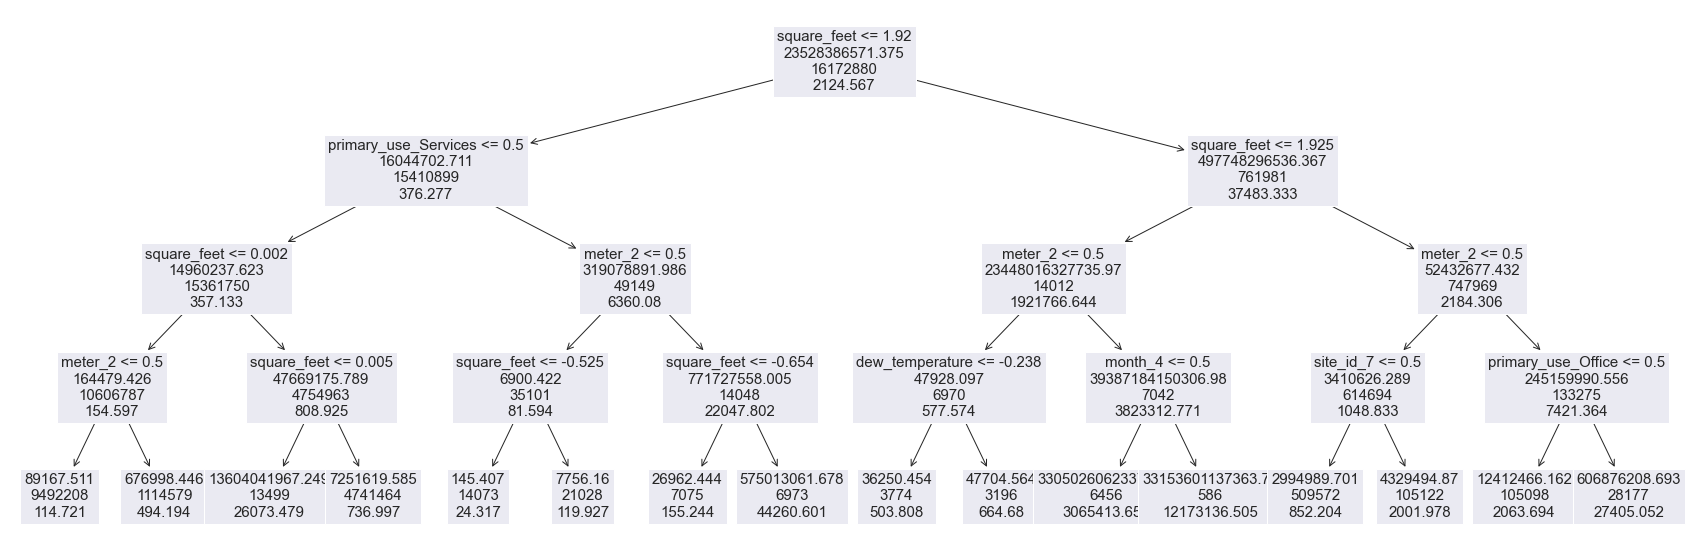

In [115]:
from sklearn.tree import plot_tree

plt.figure(figsize=(30,10))
plot_tree(DTR, feature_names=X_train.columns, fontsize=15, label="None", max_depth=4);

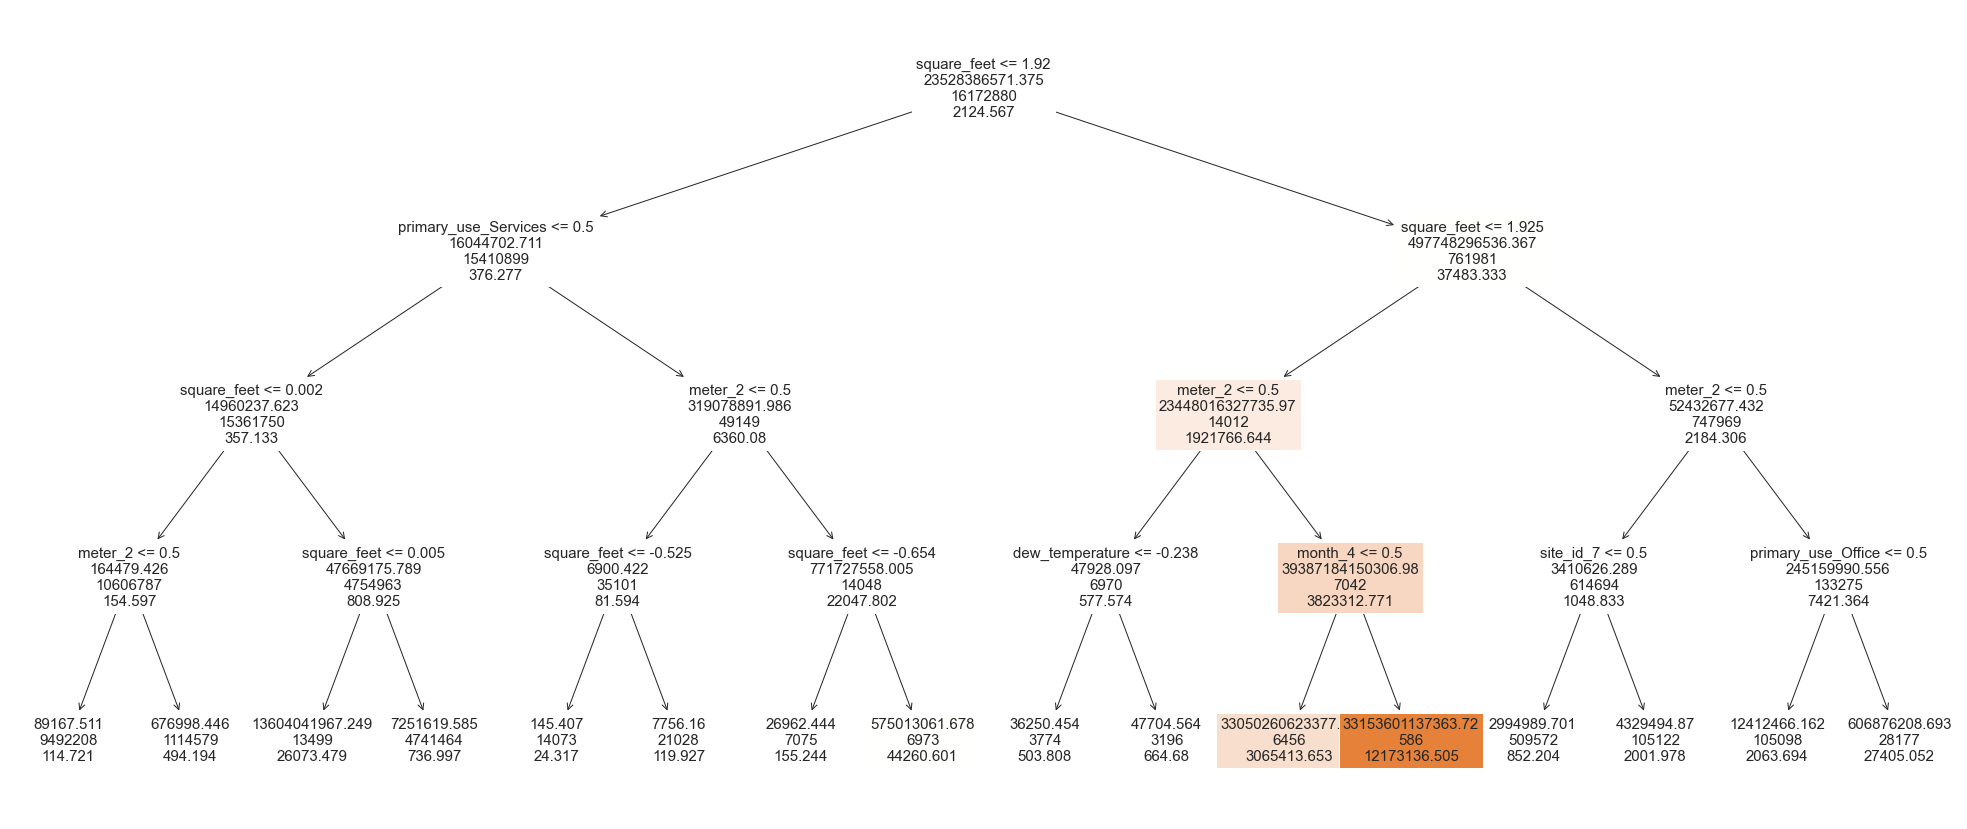

In [117]:
from sklearn.tree import plot_tree

plt.figure(figsize=(35,15))
plot_tree(DTR, feature_names=X_train.columns, fontsize=15, label="None", max_depth=4, filled=True);

In [178]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=100)

In [ ]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

parameters = {
    'num_leaves':[128,256,512],
#     'min_data_in_leaf':[1,5,10],
#     'colsample_bytree':[0.8,1],
#     'n_estimators':[100,150],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'subsample': [5],
#     'subsample_freq': [1],
#     'colsample_bytree': [.8],
    
#     'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500],
    
    'objective':['regression'],
    'boosting_type': ['gbdt'],
    'metric': ['rmse'],
    'n_jobs': [-1],
    'tree_learner': ['serial'],
    'colsample_bytree': [0.7],
    'subsample_freq': [1],
    'subsample': [0.7],
    'max_bin': [255],
    'verbose': [-1],
#     'seed': [42], 
}


LGBMR = lgb.LGBMRegressor(random_state=100)
grid = GridSearchCV(LGBMR, parameters, cv=10, scoring="neg_root_mean_squared_error")
grid.fit(X_train, y_train)

In [ ]:
print('final params', grid.best_params_)
print('best score', grid.best_score_)

In [ ]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report
from math import sqrt

pred = grid.predict(X_test)

# print(sqrt(mean_squared_log_error(y_test, pred)))
print(sqrt(mean_squared_error(y_test, pred)))

In [ ]:
# fig = plt.figure(figsize=(20, 16))
model_imp = pd.DataFrame(data=grid.best_estimator_.feature_importances_, index=X_train.columns, columns=['Imp'])
model_imp.sort_values(by='Imp', ascending=False, inplace=True)
model_imp = model_imp[:25]
sns.barplot(x=model_imp['Imp'], y=model_imp.index, data=model_imp)
plt.title('LGB Feature Importance');

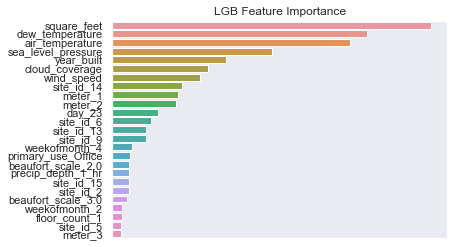

In [268]:
# fig = plt.figure(figsize=(20, 16))
model_imp = pd.DataFrame(data=grid.best_estimator_.feature_importances_, index=X_train.columns, columns=['Imp'])
model_imp.sort_values(by='Imp', ascending=False, inplace=True)
model_imp = model_imp[:25]
sns.barplot(x=model_imp['Imp'], y=model_imp.index, data=model_imp)
plt.title('LGB Feature Importance')
plt.xticks([])
ax=plt.gca()
ax.get_xaxis().set_visible(False)

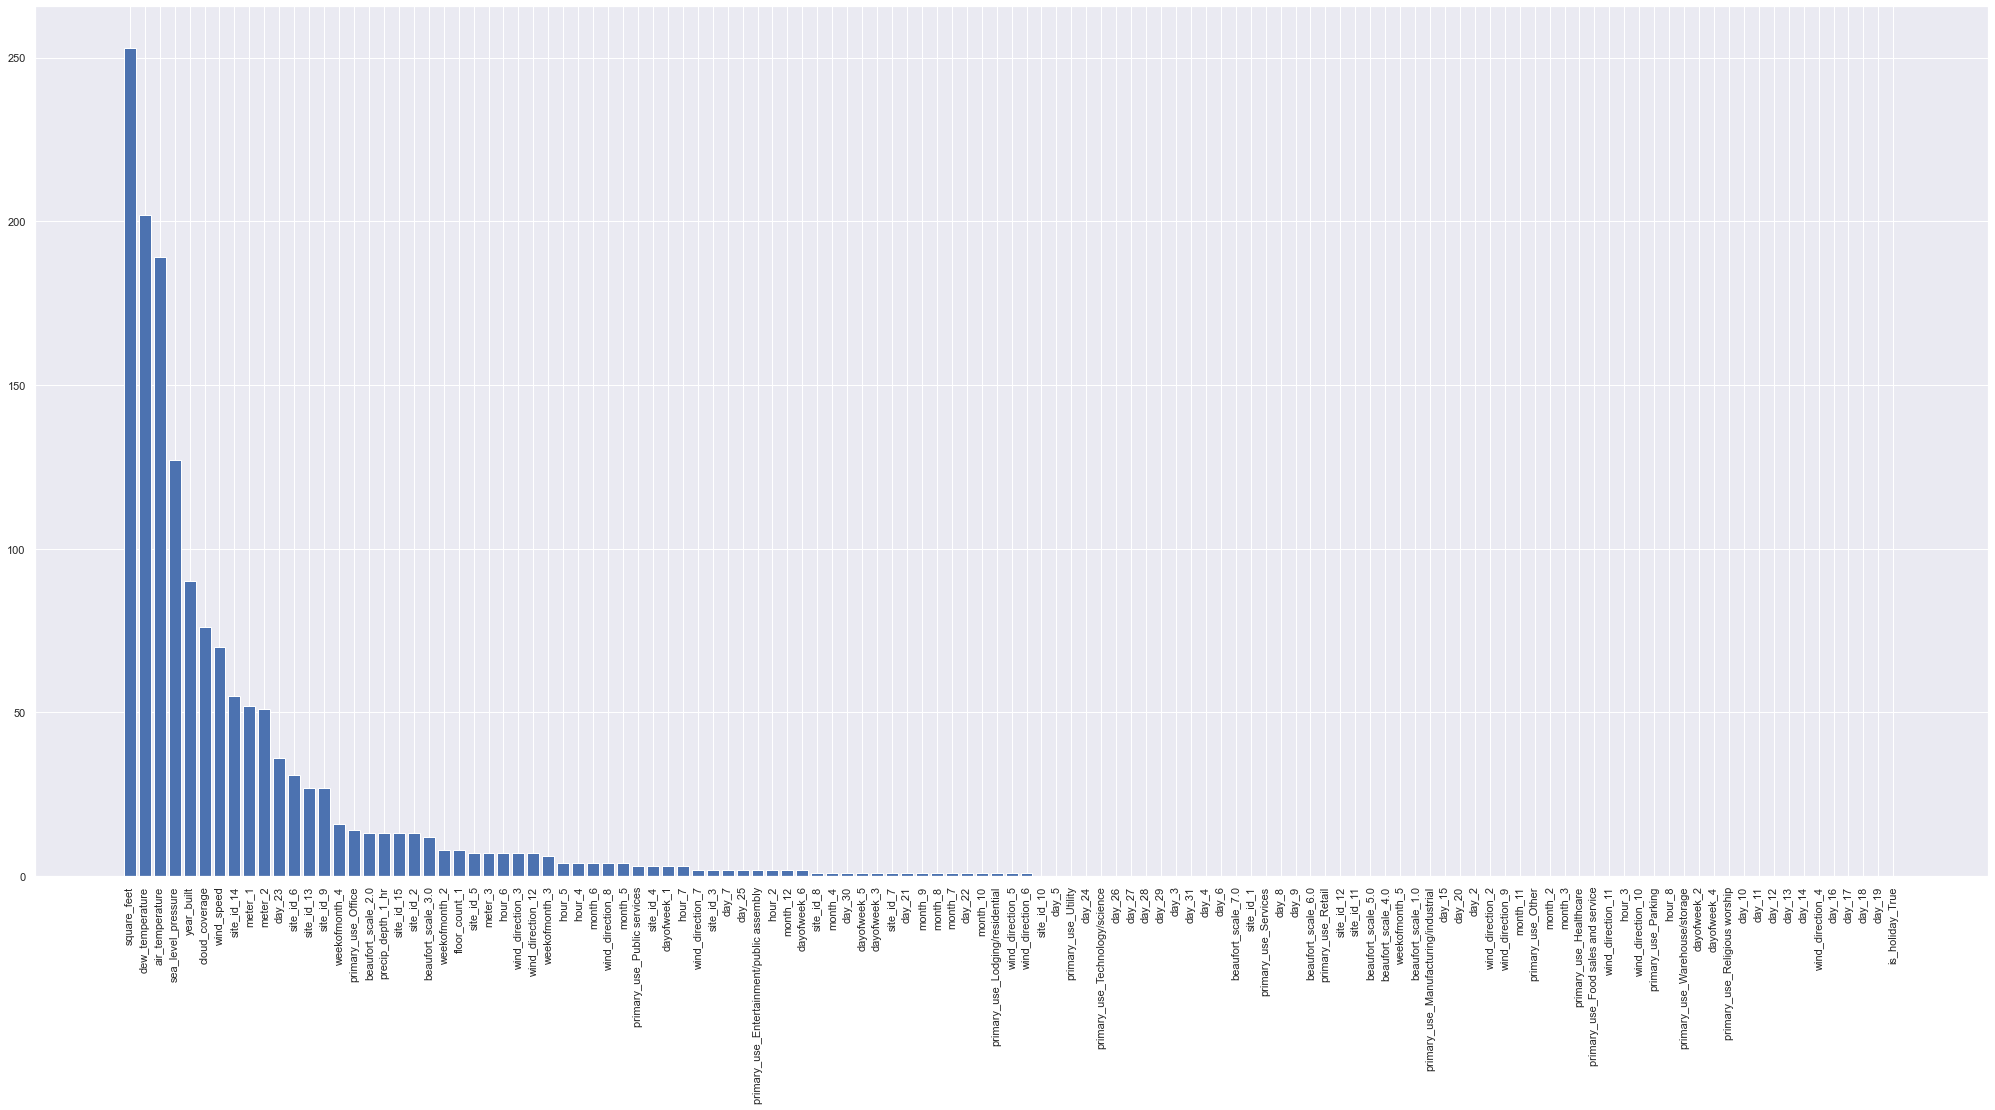

In [211]:
fig = plt.figure(figsize=(35, 16))
model_imp = pd.DataFrame(data=grid.best_estimator_.feature_importances_, index=X_train.columns, columns=['Imp'])
model_imp.sort_values(by='Imp', ascending=False, inplace=True)
plt.bar(model_imp.index,model_imp['Imp'])
plt.xticks(rotation=90)
plt.show()

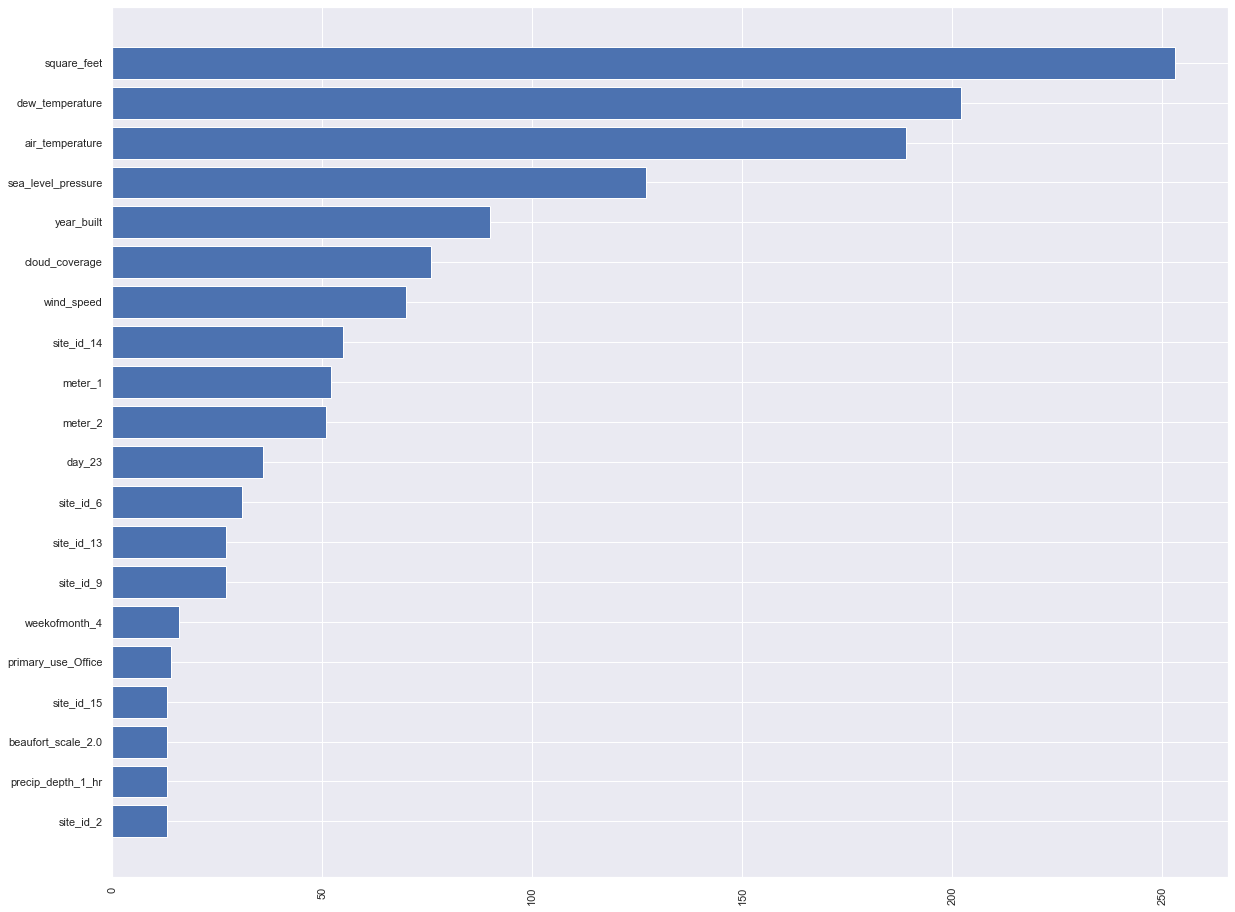

In [234]:
fig = plt.figure(figsize=(20, 16))
model_imp = pd.DataFrame(data=grid.best_estimator_.feature_importances_, index=X_train.columns, columns=['Imp'])
model_imp.sort_values(by='Imp', ascending=False, inplace=True)
model_imp = model_imp[:20]
model_imp.sort_values(by='Imp', inplace=True)
plt.barh(model_imp.index,model_imp['Imp'])
plt.xticks(rotation=90)
plt.show()

In [225]:
model_imp = pd.DataFrame(data=grid.best_estimator_.feature_importances_, index=X_train.columns, columns=['Imp'])
model_imp.sort_values(by='Imp', ascending=False, inplace=True)
model_imp[:20]

,Imp
square_feet,253
dew_temperature,202
air_temperature,189
sea_level_pressure,127
year_built,90
cloud_coverage,76
wind_speed,70
site_id_14,55
meter_1,52
meter_2,51


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
num_folds = 5
kf = KFold(n_splits = num_folds, shuffle = False, random_state = 42)
error = 0
models = []
for i, (train_index, val_index) in enumerate(kf.split(train)):
    if i + 1 < num_folds:
        continue
    print(train_index.max(), val_index.min())
    train_X = train[feat_cols].iloc[train_index]
    val_X = train[feat_cols].iloc[val_index]
    train_y = target.iloc[train_index]
    val_y = target.iloc[val_index]
    lgb_train = lgb.Dataset(train_X, train_y > 0)
    lgb_eval = lgb.Dataset(val_X, val_y > 0)
    params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': {'binary_logloss'},
            'learning_rate': 0.1,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq' : 5
            }
    gbm_class = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=(lgb_train, lgb_eval),
               early_stopping_rounds=20,
               verbose_eval = 20)
    
    lgb_train = lgb.Dataset(train_X[train_y > 0], train_y[train_y > 0])
    lgb_eval = lgb.Dataset(val_X[val_y > 0] , val_y[val_y > 0])
    params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'learning_rate': 0.5,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq' : 5
            }
    gbm_regress = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=(lgb_train, lgb_eval),
               early_stopping_rounds=20,
               verbose_eval = 20)
#     models.append(gbm)

    y_pred = (gbm_class.predict(val_X, num_iteration=gbm_class.best_iteration) > .5) *\
    (gbm_regress.predict(val_X, num_iteration=gbm_regress.best_iteration))
    error += np.sqrt(mean_squared_error(y_pred, (val_y)))/num_folds
    print(np.sqrt(mean_squared_error(y_pred, (val_y))))
    break
print(error)

In [ ]:
@jit
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_pred, y_true):
    return 'auc', fast_auc(y_true.get_label(), y_pred), True

In [ ]:
def make_val_prediction(X_train, y_train, X_val, y_val, seed=0, seed_range=3, lgb_params=None,
                        category_cols=None):
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    auc_scores = []
    best_iterations = []
    val_preds = np.zeros((X_val.shape[0], 3))

    feature_importance_df = pd.DataFrame()
    feature_importance_df['feature'] = X_train.columns.tolist()
    feature_importance_df['gain_importance'] = 0

    for i, s in enumerate(range(seed, seed + seed_range)):
        seed_everything(s)
        params = lgb_params.copy()
        params['seed'] = s
        params['bagging_seed'] = s
        params['feature_fraction_seed'] = s

        clf = lgb.train(params, train_data, 10000, valid_sets=[train_data, val_data],
                        categorical_feature=categorical_features,
                        early_stopping_rounds=500, feval=eval_auc, verbose_eval=200)

        best_iteration = clf.best_iteration
        best_iterations.append(best_iteration)
        val_pred = clf.predict(X_val, best_iteration)
        val_preds[:, i] = val_pred

        auc = fast_auc(y_val, val_pred)
        auc_scores.append(auc)
        print('seed:', s, ', auc:', auc, ', best_iteration:', best_iteration)

        feature_importance_df['gain_importance'] += clf.feature_importance('gain') / seed_range

    auc_scores = np.array(auc_scores)
    best_iterations = np.array(best_iterations)
    best_iteration = int(np.mean(best_iterations))

    avg_pred_auc = fast_auc(y_val, np.mean(val_preds, axis=1))
    print(
        f'avg pred auc: {avg_pred_auc:.5f}, avg auc: {np.mean(auc_scores):.5f}+/-{np.std(auc_scores):.5f}, avg best iteration: {best_iteration}')

    feature_importance_df = feature_importance_df.sort_values(by='gain_importance', ascending=False).reset_index(
        drop=True)
    plt.figure(figsize=(16, 12));
    sns.barplot(x="gain_importance", y="feature", data=feature_importance_df[:50])
    plt.title('LGB Features (avg over folds)');

    return feature_importance_df, best_iteration, val_preds

In [ ]:
feature_importance_df, best_iteration, val_preds = make_val_prediction(X_train, y_train, X_val, y_val, category_cols=categorical_features,
                                                       lgb_params=lgb_params)

### SHAP: 항목이 예측에 미치는 영향 파악하기
* 행: 항목	
* 빨간색: 긍정적인 영향, 1
* 파란색: 부정적인 영향, 0		

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
scores, prediction = train_model(X_train.values, y_train, X_test, folds=repeated_folds, model=model)

In [ ]:
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

In [ ]:
row_id = test["row_id"]
pred = lgbm.predict(test)

submission = pd.DataFrame({
        "row_id": row_id,
        "meter_reading": pred
    })

submission.to_csv('submission.csv', index=False)